<a href="https://colab.research.google.com/github/take2rohit/denoising_autoencoder/blob/master/colab_denoising_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset,libraries and mount colab 

In [3]:
__author__ = "Rohit Lal"
__copyright__ = "Copyright (C) 2020 Rohit Lal"
__license__ = "MIT"
__version__ = "1.0"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!git clone https://github.com/take2rohit/denoising_autoencoder.git # clone the code

Cloning into 'denoising_autoencoder'...
remote: Enumerating objects: 8764, done.
remote: Total 8764 (delta 0), reused 0 (delta 0), pack-reused 8764
Receiving objects: 100% (8764/8764), 66.01 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [6]:
!mv denoising_autoencoder/* /content/ 

In [7]:
!git clone https://github.com/ruphan/Origami-Dataset.git # clone the datasets

Cloning into 'Origami-Dataset'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 12228 (delta 0), reused 1 (delta 0), pack-reused 12226
Receiving objects: 100% (12228/12228), 74.66 MiB | 11.26 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (12203/12203), done.


In [8]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
from DAE_dataset_helper import ToTensor,Resize, Normalize
from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device=device))

Tesla K80


# Divide Dataset into train and test
- specify location of dataset `origami_dataset_dir` (downloaded from github)
- set `inp` and `out` as input to network image and output segmentation map (reconstructed results) respectively.


In [13]:
train_batch_size = 8
test_batch_size = 8
split_percent = 0.8

origami_dataset_dir = "/content/Origami-Dataset/HapticOrigami/Fold_0.5"
# origami_dataset_dir = "/content/MarowDataset"
inp='Input'
out='Output'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)), Normalize(),ToTensor()])
origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=True,**kwargs)

print(f'Training dataset size: {len(train_dataset)} \
       Testing dataset size: {len(test_dataset)}')

Training dataset size: 480        Testing dataset size: 120


# Check your Dataset 
## Remeber the below cell consumes precious GPU if used in notebook. 
Its better not run this part when u r planning to train

Input to network


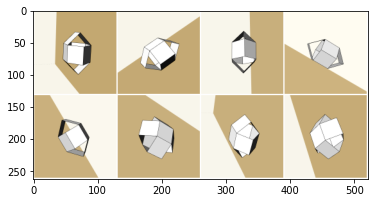

Output of network (To be verified with)


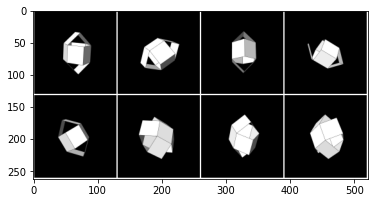

In [11]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

# Functions of training and testing of model

In [12]:
def train(model, device, train_loader, optimizer, epoch,log_interval=20):
    global store_train_loss

    model.train()
    l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l2(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))
    store_train_loss.append([epoch,loss.item()])
    scheduler.step()

def test(model, device, test_loader,save_img=False,ep=None,save_folder=None):
    model.eval()
    global store_test_loss 
    l2 = nn.MSELoss()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l2(output,target) # sum up batch loss
    test_loss /= max(1,c)
    
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    store_test_loss.append([ep,(test_loss).item()])
    if save_img:
        kwargs =  {'nrow':4, "padding":2, "pad_value":1}
        images_show = 8
        op = output[:images_show,:].cpu()
        # torchvision.utils.save_image(op,f'{ep}_re.png', **kwargs)
        tar = data[:images_show,:].cpu()
        # torchvision.utils.save_image(tar, f'{ep}_in.png',**kwargs)
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder, f'{ep}_in.png'),**kwargs)
        print('image saved')

def loss_plotter(store_train_loss, store_test_loss, epoch, location):
    store_train_loss= np.array(store_train_loss)
    store_test_loss= np.array(store_test_loss)
    plt.plot(store_train_loss[:,0], store_train_loss[:,1], label='Train Loss')
    plt.plot(store_test_loss[:,0], store_test_loss[:,1], label='Test Loss')
    plt.savefig(os.path.join(location,'plots',f'plot_{epoch}.png'))
    plt.legend()
    plt.show()

# Start Training Here
> The only variable u need to change is `root`. The code will handle foler creations

- Intermediate plots are saved in `root/plots/plot_{epoch}.png`
- Models are saved in `root/save_model_name.pt`
- Intermediate reconstructions are saved at `root`

*Remeber to delete old plots and saved results to avoid confusions between previously and recently trained*

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 	Loss: 0.242002
Train Epoch: 1 	Loss: 0.241966
Train Epoch: 1 	Loss: 0.103368


Train Epoch: 2 	Loss: 0.038686
Train Epoch: 2 	Loss: 0.029221
Train Epoch: 2 	Loss: 0.036589


Train Epoch: 3 	Loss: 0.035166
Train Epoch: 3 	Loss: 0.029547
Train Epoch: 3 	Loss: 0.032599


Train Epoch: 4 	Loss: 0.042164
Train Epoch: 4 	Loss: 0.029327
Train Epoch: 4 	Loss: 0.032057


Train Epoch: 5 	Loss: 0.032394
Train Epoch: 5 	Loss: 0.033759
Train Epoch: 5 	Loss: 0.027824


Train Epoch: 6 	Loss: 0.029227
Train Epoch: 6 	Loss: 0.023093
Train Epoch: 6 	Loss: 0.024305


Train Epoch: 7 	Loss: 0.022847
Train Epoch: 7 	Loss: 0.025426
Train Epoch: 7 	Loss: 0.027895


Train Epoch: 8 	Loss: 0.021601
Train Epoch: 8 	Loss: 0.017815
Train Epoch: 8 	Loss: 0.018042


Train Epoch: 9 	Loss: 0.017377
Train Epoch: 9 	Loss: 0.018640
Train Epoch: 9 	Loss: 0.014515


Train Epoch: 10 	Loss: 0.018632
Train Epoch: 10 	Loss: 0.017919
Train Epoch: 10 	Loss: 0.016217

Test set: Average loss: 0.0176

image saved


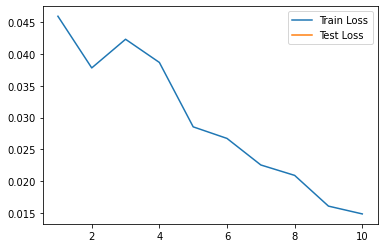

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 11 	Loss: 0.013663
Train Epoch: 11 	Loss: 0.014210
Train Epoch: 11 	Loss: 0.015295


Train Epoch: 12 	Loss: 0.017724
Train Epoch: 12 	Loss: 0.014900
Train Epoch: 12 	Loss: 0.015595


Train Epoch: 13 	Loss: 0.015594
Train Epoch: 13 	Loss: 0.012163
Train Epoch: 13 	Loss: 0.015127


Train Epoch: 14 	Loss: 0.015159
Train Epoch: 14 	Loss: 0.013808
Train Epoch: 14 	Loss: 0.013901


Train Epoch: 15 	Loss: 0.011700
Train Epoch: 15 	Loss: 0.015615
Train Epoch: 15 	Loss: 0.014360


Train Epoch: 16 	Loss: 0.012875
Train Epoch: 16 	Loss: 0.014253
Train Epoch: 16 	Loss: 0.012828


Train Epoch: 17 	Loss: 0.013241
Train Epoch: 17 	Loss: 0.013602
Train Epoch: 17 	Loss: 0.013541


Train Epoch: 18 	Loss: 0.012540
Train Epoch: 18 	Loss: 0.014944
Train Epoch: 18 	Loss: 0.013953


Train Epoch: 19 	Loss: 0.014402
Train Epoch: 19 	Loss: 0.013718
Train Epoch: 19 	Loss: 0.012872


Train Epoch: 20 	Loss: 0.010195
Train Epoch: 20 	Loss: 0.014646
Train Epoch: 20 	Loss: 0.013176

Test set: Average los

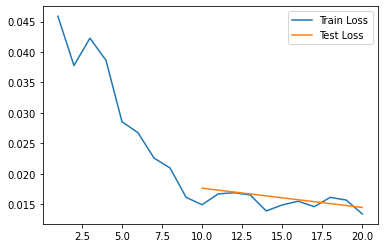

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 21 	Loss: 0.013088
Train Epoch: 21 	Loss: 0.014155
Train Epoch: 21 	Loss: 0.012285


Train Epoch: 22 	Loss: 0.012582
Train Epoch: 22 	Loss: 0.013217
Train Epoch: 22 	Loss: 0.012608


Train Epoch: 23 	Loss: 0.011966
Train Epoch: 23 	Loss: 0.014477
Train Epoch: 23 	Loss: 0.013250


Train Epoch: 24 	Loss: 0.014083
Train Epoch: 24 	Loss: 0.013989
Train Epoch: 24 	Loss: 0.013112


Train Epoch: 25 	Loss: 0.012815
Train Epoch: 25 	Loss: 0.011490
Train Epoch: 25 	Loss: 0.010922


Train Epoch: 26 	Loss: 0.011551
Train Epoch: 26 	Loss: 0.015303
Train Epoch: 26 	Loss: 0.014586


Train Epoch: 27 	Loss: 0.009953
Train Epoch: 27 	Loss: 0.010919
Train Epoch: 27 	Loss: 0.012990


Train Epoch: 28 	Loss: 0.012079
Train Epoch: 28 	Loss: 0.013630
Train Epoch: 28 	Loss: 0.012784


Train Epoch: 29 	Loss: 0.012488
Train Epoch: 29 	Loss: 0.011780
Train Epoch: 29 	Loss: 0.011749


Train Epoch: 30 	Loss: 0.013182
Train Epoch: 30 	Loss: 0.009260
Train Epoch: 30 	Loss: 0.012634

Test set: Average los

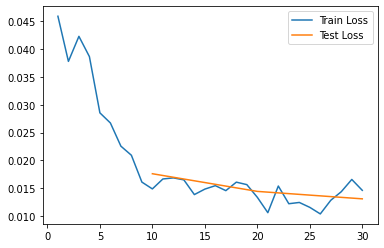

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 31 	Loss: 0.013592
Train Epoch: 31 	Loss: 0.010173
Train Epoch: 31 	Loss: 0.010571


Train Epoch: 32 	Loss: 0.011551
Train Epoch: 32 	Loss: 0.011186
Train Epoch: 32 	Loss: 0.011911


Train Epoch: 33 	Loss: 0.011349
Train Epoch: 33 	Loss: 0.012259
Train Epoch: 33 	Loss: 0.010338


Train Epoch: 34 	Loss: 0.008648
Train Epoch: 34 	Loss: 0.014234
Train Epoch: 34 	Loss: 0.011934


Train Epoch: 35 	Loss: 0.012948
Train Epoch: 35 	Loss: 0.012624
Train Epoch: 35 	Loss: 0.014701


Train Epoch: 36 	Loss: 0.011610
Train Epoch: 36 	Loss: 0.011866
Train Epoch: 36 	Loss: 0.014513


Train Epoch: 37 	Loss: 0.010566
Train Epoch: 37 	Loss: 0.013568
Train Epoch: 37 	Loss: 0.012812


Train Epoch: 38 	Loss: 0.012213
Train Epoch: 38 	Loss: 0.010571
Train Epoch: 38 	Loss: 0.014854


Train Epoch: 39 	Loss: 0.012453
Train Epoch: 39 	Loss: 0.012190
Train Epoch: 39 	Loss: 0.013407


Train Epoch: 40 	Loss: 0.010255
Train Epoch: 40 	Loss: 0.013085
Train Epoch: 40 	Loss: 0.009584

Test set: Average los

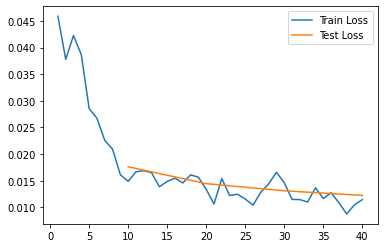

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 41 	Loss: 0.010574
Train Epoch: 41 	Loss: 0.014177
Train Epoch: 41 	Loss: 0.008017


Train Epoch: 42 	Loss: 0.011701
Train Epoch: 42 	Loss: 0.011595
Train Epoch: 42 	Loss: 0.012958


Train Epoch: 43 	Loss: 0.012629
Train Epoch: 43 	Loss: 0.009612
Train Epoch: 43 	Loss: 0.009460


Train Epoch: 44 	Loss: 0.010454
Train Epoch: 44 	Loss: 0.011170
Train Epoch: 44 	Loss: 0.012918


Train Epoch: 45 	Loss: 0.011989
Train Epoch: 45 	Loss: 0.009072
Train Epoch: 45 	Loss: 0.012268


Train Epoch: 46 	Loss: 0.010483
Train Epoch: 46 	Loss: 0.012699
Train Epoch: 46 	Loss: 0.010985


Train Epoch: 47 	Loss: 0.009355
Train Epoch: 47 	Loss: 0.012251
Train Epoch: 47 	Loss: 0.010603


Train Epoch: 48 	Loss: 0.010586
Train Epoch: 48 	Loss: 0.008441
Train Epoch: 48 	Loss: 0.007481


Train Epoch: 49 	Loss: 0.009326
Train Epoch: 49 	Loss: 0.010758
Train Epoch: 49 	Loss: 0.012636


Train Epoch: 50 	Loss: 0.009055
Train Epoch: 50 	Loss: 0.012142
Train Epoch: 50 	Loss: 0.010552

Test set: Average los

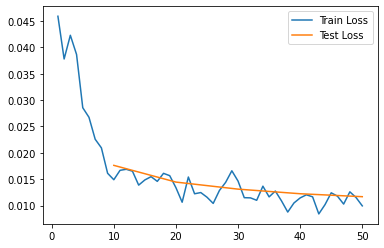

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 51 	Loss: 0.009081
Train Epoch: 51 	Loss: 0.010621
Train Epoch: 51 	Loss: 0.011307


Train Epoch: 52 	Loss: 0.009354
Train Epoch: 52 	Loss: 0.007561
Train Epoch: 52 	Loss: 0.009622


Train Epoch: 53 	Loss: 0.009791
Train Epoch: 53 	Loss: 0.012047
Train Epoch: 53 	Loss: 0.011391


Train Epoch: 54 	Loss: 0.011374
Train Epoch: 54 	Loss: 0.009727
Train Epoch: 54 	Loss: 0.008014


Train Epoch: 55 	Loss: 0.008545
Train Epoch: 55 	Loss: 0.010071
Train Epoch: 55 	Loss: 0.009964


Train Epoch: 56 	Loss: 0.011545
Train Epoch: 56 	Loss: 0.008428
Train Epoch: 56 	Loss: 0.008418


Train Epoch: 57 	Loss: 0.013503
Train Epoch: 57 	Loss: 0.010983
Train Epoch: 57 	Loss: 0.012030


Train Epoch: 58 	Loss: 0.010633
Train Epoch: 58 	Loss: 0.008981
Train Epoch: 58 	Loss: 0.010178


Train Epoch: 59 	Loss: 0.009991
Train Epoch: 59 	Loss: 0.008065
Train Epoch: 59 	Loss: 0.010150


Train Epoch: 60 	Loss: 0.010225
Train Epoch: 60 	Loss: 0.008311
Train Epoch: 60 	Loss: 0.007995

Test set: Average los

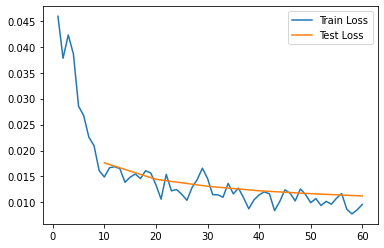

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 61 	Loss: 0.007785
Train Epoch: 61 	Loss: 0.012772
Train Epoch: 61 	Loss: 0.012689


Train Epoch: 62 	Loss: 0.013872
Train Epoch: 62 	Loss: 0.009289
Train Epoch: 62 	Loss: 0.010941


Train Epoch: 63 	Loss: 0.007963
Train Epoch: 63 	Loss: 0.010940
Train Epoch: 63 	Loss: 0.009403


Train Epoch: 64 	Loss: 0.011129
Train Epoch: 64 	Loss: 0.010704
Train Epoch: 64 	Loss: 0.011801


Train Epoch: 65 	Loss: 0.009110
Train Epoch: 65 	Loss: 0.008931
Train Epoch: 65 	Loss: 0.012284


Train Epoch: 66 	Loss: 0.008561
Train Epoch: 66 	Loss: 0.008576
Train Epoch: 66 	Loss: 0.008495


Train Epoch: 67 	Loss: 0.009640
Train Epoch: 67 	Loss: 0.010195
Train Epoch: 67 	Loss: 0.011092


Train Epoch: 68 	Loss: 0.010221
Train Epoch: 68 	Loss: 0.009983
Train Epoch: 68 	Loss: 0.011619


Train Epoch: 69 	Loss: 0.008194
Train Epoch: 69 	Loss: 0.009174
Train Epoch: 69 	Loss: 0.010570


Train Epoch: 70 	Loss: 0.010406
Train Epoch: 70 	Loss: 0.008272
Train Epoch: 70 	Loss: 0.008769

Test set: Average los

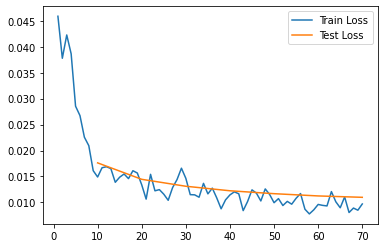

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 71 	Loss: 0.011236
Train Epoch: 71 	Loss: 0.011083
Train Epoch: 71 	Loss: 0.010150


Train Epoch: 72 	Loss: 0.008376
Train Epoch: 72 	Loss: 0.008198
Train Epoch: 72 	Loss: 0.009532


Train Epoch: 73 	Loss: 0.007328
Train Epoch: 73 	Loss: 0.010531
Train Epoch: 73 	Loss: 0.009879


Train Epoch: 74 	Loss: 0.007422
Train Epoch: 74 	Loss: 0.010476
Train Epoch: 74 	Loss: 0.008119


Train Epoch: 75 	Loss: 0.008766
Train Epoch: 75 	Loss: 0.009575
Train Epoch: 75 	Loss: 0.009135


Train Epoch: 76 	Loss: 0.009852
Train Epoch: 76 	Loss: 0.010813
Train Epoch: 76 	Loss: 0.009981


Train Epoch: 77 	Loss: 0.009132
Train Epoch: 77 	Loss: 0.011062
Train Epoch: 77 	Loss: 0.009368


Train Epoch: 78 	Loss: 0.009661
Train Epoch: 78 	Loss: 0.010522
Train Epoch: 78 	Loss: 0.010295


Train Epoch: 79 	Loss: 0.009118
Train Epoch: 79 	Loss: 0.010483
Train Epoch: 79 	Loss: 0.009870


Train Epoch: 80 	Loss: 0.010704
Train Epoch: 80 	Loss: 0.010936
Train Epoch: 80 	Loss: 0.009112

Test set: Average los

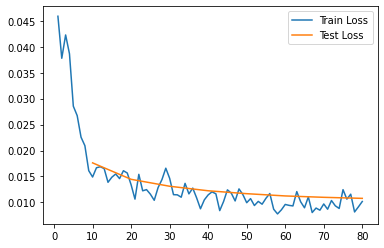

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 81 	Loss: 0.010211
Train Epoch: 81 	Loss: 0.009240
Train Epoch: 81 	Loss: 0.008987


Train Epoch: 82 	Loss: 0.009859
Train Epoch: 82 	Loss: 0.008085
Train Epoch: 82 	Loss: 0.009142


Train Epoch: 83 	Loss: 0.008437
Train Epoch: 83 	Loss: 0.009933
Train Epoch: 83 	Loss: 0.009688


Train Epoch: 84 	Loss: 0.010248
Train Epoch: 84 	Loss: 0.008463
Train Epoch: 84 	Loss: 0.008463


Train Epoch: 85 	Loss: 0.010720
Train Epoch: 85 	Loss: 0.009502
Train Epoch: 85 	Loss: 0.007904


Train Epoch: 86 	Loss: 0.007646
Train Epoch: 86 	Loss: 0.010549
Train Epoch: 86 	Loss: 0.008564


Train Epoch: 87 	Loss: 0.010015
Train Epoch: 87 	Loss: 0.009319
Train Epoch: 87 	Loss: 0.009999


Train Epoch: 88 	Loss: 0.009933
Train Epoch: 88 	Loss: 0.009159
Train Epoch: 88 	Loss: 0.008806


Train Epoch: 89 	Loss: 0.011334
Train Epoch: 89 	Loss: 0.006918
Train Epoch: 89 	Loss: 0.010611


Train Epoch: 90 	Loss: 0.009944
Train Epoch: 90 	Loss: 0.010294
Train Epoch: 90 	Loss: 0.007686

Test set: Average los

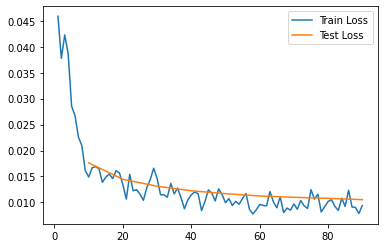

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 91 	Loss: 0.009738
Train Epoch: 91 	Loss: 0.008253
Train Epoch: 91 	Loss: 0.008094


Train Epoch: 92 	Loss: 0.009701
Train Epoch: 92 	Loss: 0.010291
Train Epoch: 92 	Loss: 0.010502


Train Epoch: 93 	Loss: 0.010614
Train Epoch: 93 	Loss: 0.009341
Train Epoch: 93 	Loss: 0.008494


Train Epoch: 94 	Loss: 0.008887
Train Epoch: 94 	Loss: 0.010891
Train Epoch: 94 	Loss: 0.007756


Train Epoch: 95 	Loss: 0.007695
Train Epoch: 95 	Loss: 0.008015
Train Epoch: 95 	Loss: 0.010121


Train Epoch: 96 	Loss: 0.008485
Train Epoch: 96 	Loss: 0.009172
Train Epoch: 96 	Loss: 0.010214


Train Epoch: 97 	Loss: 0.008096
Train Epoch: 97 	Loss: 0.010794
Train Epoch: 97 	Loss: 0.009299


Train Epoch: 98 	Loss: 0.007345
Train Epoch: 98 	Loss: 0.007674
Train Epoch: 98 	Loss: 0.008644


Train Epoch: 99 	Loss: 0.010075
Train Epoch: 99 	Loss: 0.008594
Train Epoch: 99 	Loss: 0.009879


Train Epoch: 100 	Loss: 0.009306
Train Epoch: 100 	Loss: 0.008846
Train Epoch: 100 	Loss: 0.008596

Test set: Average 

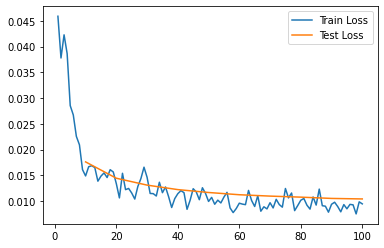

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 101 	Loss: 0.009854
Train Epoch: 101 	Loss: 0.007083
Train Epoch: 101 	Loss: 0.010024


Train Epoch: 102 	Loss: 0.009812
Train Epoch: 102 	Loss: 0.007666
Train Epoch: 102 	Loss: 0.009882


Train Epoch: 103 	Loss: 0.009257
Train Epoch: 103 	Loss: 0.010124
Train Epoch: 103 	Loss: 0.010953


Train Epoch: 104 	Loss: 0.009568
Train Epoch: 104 	Loss: 0.008382
Train Epoch: 104 	Loss: 0.009076


Train Epoch: 105 	Loss: 0.008558
Train Epoch: 105 	Loss: 0.009195
Train Epoch: 105 	Loss: 0.009892


Train Epoch: 106 	Loss: 0.010161
Train Epoch: 106 	Loss: 0.008869
Train Epoch: 106 	Loss: 0.008822


Train Epoch: 107 	Loss: 0.009943
Train Epoch: 107 	Loss: 0.007872
Train Epoch: 107 	Loss: 0.009768


Train Epoch: 108 	Loss: 0.007271
Train Epoch: 108 	Loss: 0.008063
Train Epoch: 108 	Loss: 0.009074


Train Epoch: 109 	Loss: 0.008010
Train Epoch: 109 	Loss: 0.008335
Train Epoch: 109 	Loss: 0.010483


Train Epoch: 110 	Loss: 0.010056
Train Epoch: 110 	Loss: 0.009749
Train Epoch: 110 	Loss: 0

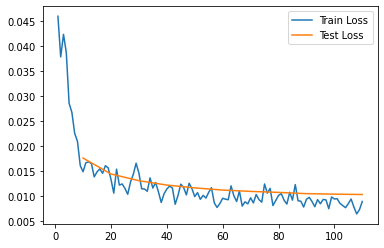

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 111 	Loss: 0.009297
Train Epoch: 111 	Loss: 0.007562
Train Epoch: 111 	Loss: 0.008210


Train Epoch: 112 	Loss: 0.007252
Train Epoch: 112 	Loss: 0.009650
Train Epoch: 112 	Loss: 0.007703


Train Epoch: 113 	Loss: 0.007527
Train Epoch: 113 	Loss: 0.009986
Train Epoch: 113 	Loss: 0.009824


Train Epoch: 114 	Loss: 0.007704
Train Epoch: 114 	Loss: 0.009353
Train Epoch: 114 	Loss: 0.006748


Train Epoch: 115 	Loss: 0.008223
Train Epoch: 115 	Loss: 0.008922
Train Epoch: 115 	Loss: 0.008474


Train Epoch: 116 	Loss: 0.009327
Train Epoch: 116 	Loss: 0.009233
Train Epoch: 116 	Loss: 0.008436


Train Epoch: 117 	Loss: 0.011062
Train Epoch: 117 	Loss: 0.008168
Train Epoch: 117 	Loss: 0.006593


Train Epoch: 118 	Loss: 0.006392
Train Epoch: 118 	Loss: 0.007359
Train Epoch: 118 	Loss: 0.007188


Train Epoch: 119 	Loss: 0.007215
Train Epoch: 119 	Loss: 0.009169
Train Epoch: 119 	Loss: 0.007727


Train Epoch: 120 	Loss: 0.006355
Train Epoch: 120 	Loss: 0.006576
Train Epoch: 120 	Loss: 0

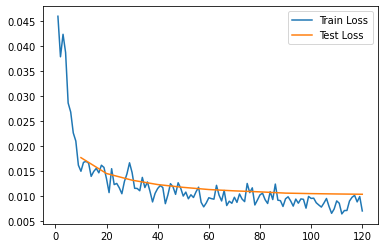

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 121 	Loss: 0.008457
Train Epoch: 121 	Loss: 0.007207
Train Epoch: 121 	Loss: 0.007940


Train Epoch: 122 	Loss: 0.009900
Train Epoch: 122 	Loss: 0.009051
Train Epoch: 122 	Loss: 0.010052


Train Epoch: 123 	Loss: 0.008550
Train Epoch: 123 	Loss: 0.009855
Train Epoch: 123 	Loss: 0.007195


Train Epoch: 124 	Loss: 0.007696
Train Epoch: 124 	Loss: 0.009398
Train Epoch: 124 	Loss: 0.010458


Train Epoch: 125 	Loss: 0.007545
Train Epoch: 125 	Loss: 0.010361
Train Epoch: 125 	Loss: 0.009339


Train Epoch: 126 	Loss: 0.007715
Train Epoch: 126 	Loss: 0.007664
Train Epoch: 126 	Loss: 0.007287


Train Epoch: 127 	Loss: 0.009928
Train Epoch: 127 	Loss: 0.007505
Train Epoch: 127 	Loss: 0.008817


Train Epoch: 128 	Loss: 0.008098
Train Epoch: 128 	Loss: 0.009344
Train Epoch: 128 	Loss: 0.008802


Train Epoch: 129 	Loss: 0.008475
Train Epoch: 129 	Loss: 0.007189
Train Epoch: 129 	Loss: 0.007730


Train Epoch: 130 	Loss: 0.008570
Train Epoch: 130 	Loss: 0.009327
Train Epoch: 130 	Loss: 0

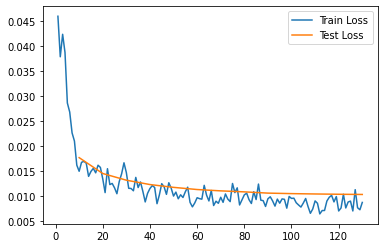

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 131 	Loss: 0.009432
Train Epoch: 131 	Loss: 0.008283
Train Epoch: 131 	Loss: 0.007805


Train Epoch: 132 	Loss: 0.008654
Train Epoch: 132 	Loss: 0.007317
Train Epoch: 132 	Loss: 0.008237


Train Epoch: 133 	Loss: 0.008322
Train Epoch: 133 	Loss: 0.006777
Train Epoch: 133 	Loss: 0.009043


Train Epoch: 134 	Loss: 0.008401
Train Epoch: 134 	Loss: 0.007515
Train Epoch: 134 	Loss: 0.008646


Train Epoch: 135 	Loss: 0.006889
Train Epoch: 135 	Loss: 0.009361
Train Epoch: 135 	Loss: 0.008187


Train Epoch: 136 	Loss: 0.009669
Train Epoch: 136 	Loss: 0.009078
Train Epoch: 136 	Loss: 0.008748


Train Epoch: 137 	Loss: 0.008557
Train Epoch: 137 	Loss: 0.009944
Train Epoch: 137 	Loss: 0.010894


Train Epoch: 138 	Loss: 0.010585
Train Epoch: 138 	Loss: 0.009143
Train Epoch: 138 	Loss: 0.007369


Train Epoch: 139 	Loss: 0.008637
Train Epoch: 139 	Loss: 0.006395
Train Epoch: 139 	Loss: 0.008798


Train Epoch: 140 	Loss: 0.008291
Train Epoch: 140 	Loss: 0.007016
Train Epoch: 140 	Loss: 0

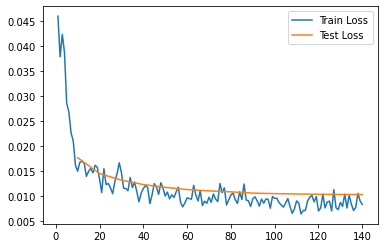

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 141 	Loss: 0.007158
Train Epoch: 141 	Loss: 0.006651
Train Epoch: 141 	Loss: 0.006673


Train Epoch: 142 	Loss: 0.007530
Train Epoch: 142 	Loss: 0.007929
Train Epoch: 142 	Loss: 0.009124


Train Epoch: 143 	Loss: 0.010059
Train Epoch: 143 	Loss: 0.006943
Train Epoch: 143 	Loss: 0.008178


Train Epoch: 144 	Loss: 0.007757
Train Epoch: 144 	Loss: 0.008796
Train Epoch: 144 	Loss: 0.006781


Train Epoch: 145 	Loss: 0.009426
Train Epoch: 145 	Loss: 0.009366
Train Epoch: 145 	Loss: 0.008297


Train Epoch: 146 	Loss: 0.008769
Train Epoch: 146 	Loss: 0.008899
Train Epoch: 146 	Loss: 0.009210


Train Epoch: 147 	Loss: 0.008274
Train Epoch: 147 	Loss: 0.007356
Train Epoch: 147 	Loss: 0.008542


Train Epoch: 148 	Loss: 0.009181
Train Epoch: 148 	Loss: 0.007707
Train Epoch: 148 	Loss: 0.009270


Train Epoch: 149 	Loss: 0.010740
Train Epoch: 149 	Loss: 0.009669
Train Epoch: 149 	Loss: 0.008718


Train Epoch: 150 	Loss: 0.008813
Train Epoch: 150 	Loss: 0.008361
Train Epoch: 150 	Loss: 0

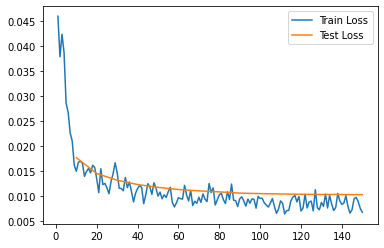

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 151 	Loss: 0.009725
Train Epoch: 151 	Loss: 0.007515
Train Epoch: 151 	Loss: 0.010338


Train Epoch: 152 	Loss: 0.009153
Train Epoch: 152 	Loss: 0.008552
Train Epoch: 152 	Loss: 0.009263


Train Epoch: 153 	Loss: 0.008108
Train Epoch: 153 	Loss: 0.007459
Train Epoch: 153 	Loss: 0.007250


Train Epoch: 154 	Loss: 0.010469
Train Epoch: 154 	Loss: 0.007297
Train Epoch: 154 	Loss: 0.009294


Train Epoch: 155 	Loss: 0.009845
Train Epoch: 155 	Loss: 0.008121
Train Epoch: 155 	Loss: 0.008403


Train Epoch: 156 	Loss: 0.008233
Train Epoch: 156 	Loss: 0.008045
Train Epoch: 156 	Loss: 0.007644


Train Epoch: 157 	Loss: 0.009714
Train Epoch: 157 	Loss: 0.008772
Train Epoch: 157 	Loss: 0.008576


Train Epoch: 158 	Loss: 0.009305
Train Epoch: 158 	Loss: 0.006564
Train Epoch: 158 	Loss: 0.009059


Train Epoch: 159 	Loss: 0.007913
Train Epoch: 159 	Loss: 0.007418
Train Epoch: 159 	Loss: 0.008439


Train Epoch: 160 	Loss: 0.007495
Train Epoch: 160 	Loss: 0.007705
Train Epoch: 160 	Loss: 0

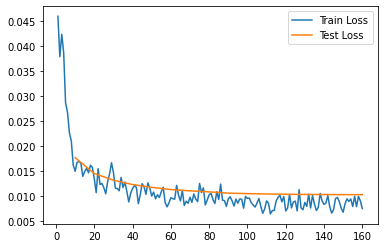

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 161 	Loss: 0.008140
Train Epoch: 161 	Loss: 0.009500
Train Epoch: 161 	Loss: 0.007980


Train Epoch: 162 	Loss: 0.008902
Train Epoch: 162 	Loss: 0.009892
Train Epoch: 162 	Loss: 0.008739


Train Epoch: 163 	Loss: 0.007617
Train Epoch: 163 	Loss: 0.008264
Train Epoch: 163 	Loss: 0.009423


Train Epoch: 164 	Loss: 0.009288
Train Epoch: 164 	Loss: 0.009560
Train Epoch: 164 	Loss: 0.007861


Train Epoch: 165 	Loss: 0.008578
Train Epoch: 165 	Loss: 0.008657
Train Epoch: 165 	Loss: 0.008249


Train Epoch: 166 	Loss: 0.008303
Train Epoch: 166 	Loss: 0.007664
Train Epoch: 166 	Loss: 0.007996


Train Epoch: 167 	Loss: 0.006755
Train Epoch: 167 	Loss: 0.008392
Train Epoch: 167 	Loss: 0.007448


Train Epoch: 168 	Loss: 0.007778
Train Epoch: 168 	Loss: 0.009808
Train Epoch: 168 	Loss: 0.008801


Train Epoch: 169 	Loss: 0.008173
Train Epoch: 169 	Loss: 0.008454
Train Epoch: 169 	Loss: 0.008006


Train Epoch: 170 	Loss: 0.006571
Train Epoch: 170 	Loss: 0.008858
Train Epoch: 170 	Loss: 0

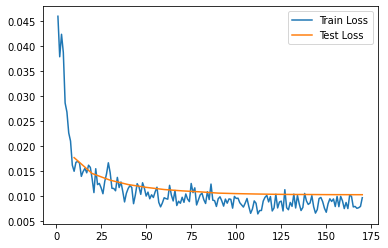

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 171 	Loss: 0.009486
Train Epoch: 171 	Loss: 0.008110
Train Epoch: 171 	Loss: 0.008567


Train Epoch: 172 	Loss: 0.008004
Train Epoch: 172 	Loss: 0.009326
Train Epoch: 172 	Loss: 0.007359


Train Epoch: 173 	Loss: 0.007046
Train Epoch: 173 	Loss: 0.008182
Train Epoch: 173 	Loss: 0.007217


Train Epoch: 174 	Loss: 0.008480
Train Epoch: 174 	Loss: 0.006555
Train Epoch: 174 	Loss: 0.009066


Train Epoch: 175 	Loss: 0.007208
Train Epoch: 175 	Loss: 0.007814
Train Epoch: 175 	Loss: 0.009300


Train Epoch: 176 	Loss: 0.011207
Train Epoch: 176 	Loss: 0.007768
Train Epoch: 176 	Loss: 0.008242


Train Epoch: 177 	Loss: 0.008144
Train Epoch: 177 	Loss: 0.007358
Train Epoch: 177 	Loss: 0.007700


Train Epoch: 178 	Loss: 0.010113
Train Epoch: 178 	Loss: 0.009246
Train Epoch: 178 	Loss: 0.007047


Train Epoch: 179 	Loss: 0.008349
Train Epoch: 179 	Loss: 0.006953
Train Epoch: 179 	Loss: 0.007480


Train Epoch: 180 	Loss: 0.007740
Train Epoch: 180 	Loss: 0.007824
Train Epoch: 180 	Loss: 0

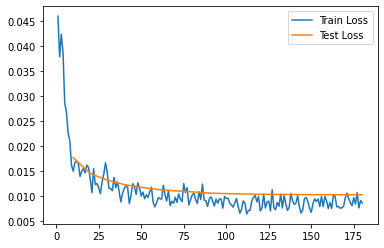

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 181 	Loss: 0.009737
Train Epoch: 181 	Loss: 0.006104
Train Epoch: 181 	Loss: 0.009582


Train Epoch: 182 	Loss: 0.009356
Train Epoch: 182 	Loss: 0.007680
Train Epoch: 182 	Loss: 0.007149


Train Epoch: 183 	Loss: 0.008569
Train Epoch: 183 	Loss: 0.006219
Train Epoch: 183 	Loss: 0.009760


Train Epoch: 184 	Loss: 0.011565
Train Epoch: 184 	Loss: 0.009432
Train Epoch: 184 	Loss: 0.008498


Train Epoch: 185 	Loss: 0.007943
Train Epoch: 185 	Loss: 0.007243
Train Epoch: 185 	Loss: 0.008805


Train Epoch: 186 	Loss: 0.008376
Train Epoch: 186 	Loss: 0.008294
Train Epoch: 186 	Loss: 0.009873


Train Epoch: 187 	Loss: 0.008495
Train Epoch: 187 	Loss: 0.008722
Train Epoch: 187 	Loss: 0.008684


Train Epoch: 188 	Loss: 0.008901
Train Epoch: 188 	Loss: 0.010480
Train Epoch: 188 	Loss: 0.008196


Train Epoch: 189 	Loss: 0.007477
Train Epoch: 189 	Loss: 0.009188
Train Epoch: 189 	Loss: 0.008015


Train Epoch: 190 	Loss: 0.008608
Train Epoch: 190 	Loss: 0.008869
Train Epoch: 190 	Loss: 0

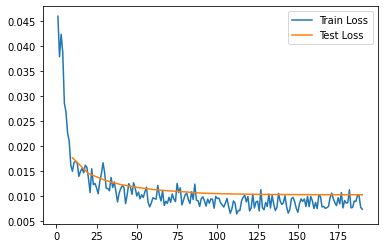

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 191 	Loss: 0.007174
Train Epoch: 191 	Loss: 0.010671
Train Epoch: 191 	Loss: 0.008505


Train Epoch: 192 	Loss: 0.008184
Train Epoch: 192 	Loss: 0.008210
Train Epoch: 192 	Loss: 0.006858


Train Epoch: 193 	Loss: 0.008750
Train Epoch: 193 	Loss: 0.009720
Train Epoch: 193 	Loss: 0.009803


Train Epoch: 194 	Loss: 0.006490
Train Epoch: 194 	Loss: 0.008860
Train Epoch: 194 	Loss: 0.008388


Train Epoch: 195 	Loss: 0.008205
Train Epoch: 195 	Loss: 0.010351
Train Epoch: 195 	Loss: 0.007648


Train Epoch: 196 	Loss: 0.008606
Train Epoch: 196 	Loss: 0.006709
Train Epoch: 196 	Loss: 0.009590


Train Epoch: 197 	Loss: 0.009932
Train Epoch: 197 	Loss: 0.010389
Train Epoch: 197 	Loss: 0.007341


Train Epoch: 198 	Loss: 0.006976
Train Epoch: 198 	Loss: 0.007962
Train Epoch: 198 	Loss: 0.007672


Train Epoch: 199 	Loss: 0.009633
Train Epoch: 199 	Loss: 0.008834
Train Epoch: 199 	Loss: 0.009676


Train Epoch: 200 	Loss: 0.008532
Train Epoch: 200 	Loss: 0.008823
Train Epoch: 200 	Loss: 0

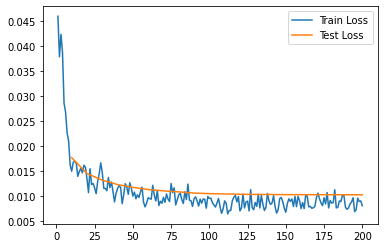

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 201 	Loss: 0.008029
Train Epoch: 201 	Loss: 0.007883
Train Epoch: 201 	Loss: 0.010149


Train Epoch: 202 	Loss: 0.008654
Train Epoch: 202 	Loss: 0.008490
Train Epoch: 202 	Loss: 0.009013


Train Epoch: 203 	Loss: 0.007365
Train Epoch: 203 	Loss: 0.009334
Train Epoch: 203 	Loss: 0.008698


Train Epoch: 204 	Loss: 0.007965
Train Epoch: 204 	Loss: 0.010630
Train Epoch: 204 	Loss: 0.011777


Train Epoch: 205 	Loss: 0.008036
Train Epoch: 205 	Loss: 0.009334
Train Epoch: 205 	Loss: 0.007359


Train Epoch: 206 	Loss: 0.008680
Train Epoch: 206 	Loss: 0.008751
Train Epoch: 206 	Loss: 0.007961


Train Epoch: 207 	Loss: 0.008762
Train Epoch: 207 	Loss: 0.009570
Train Epoch: 207 	Loss: 0.009749


Train Epoch: 208 	Loss: 0.009530
Train Epoch: 208 	Loss: 0.009126
Train Epoch: 208 	Loss: 0.008061


Train Epoch: 209 	Loss: 0.011142
Train Epoch: 209 	Loss: 0.007769
Train Epoch: 209 	Loss: 0.007800


Train Epoch: 210 	Loss: 0.007364
Train Epoch: 210 	Loss: 0.008371
Train Epoch: 210 	Loss: 0

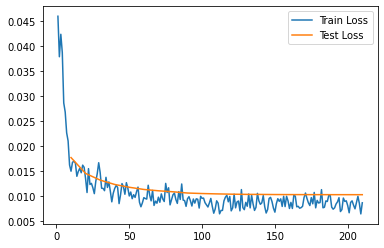

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 211 	Loss: 0.009538
Train Epoch: 211 	Loss: 0.008264
Train Epoch: 211 	Loss: 0.010443


Train Epoch: 212 	Loss: 0.009149
Train Epoch: 212 	Loss: 0.006717
Train Epoch: 212 	Loss: 0.007831


Train Epoch: 213 	Loss: 0.007272
Train Epoch: 213 	Loss: 0.009398
Train Epoch: 213 	Loss: 0.007396


Train Epoch: 214 	Loss: 0.007987
Train Epoch: 214 	Loss: 0.010225
Train Epoch: 214 	Loss: 0.007006


Train Epoch: 215 	Loss: 0.009261
Train Epoch: 215 	Loss: 0.008978
Train Epoch: 215 	Loss: 0.006874


Train Epoch: 216 	Loss: 0.007709
Train Epoch: 216 	Loss: 0.010805
Train Epoch: 216 	Loss: 0.008983


Train Epoch: 217 	Loss: 0.008963
Train Epoch: 217 	Loss: 0.011163
Train Epoch: 217 	Loss: 0.008615


Train Epoch: 218 	Loss: 0.008124
Train Epoch: 218 	Loss: 0.006725
Train Epoch: 218 	Loss: 0.007193


Train Epoch: 219 	Loss: 0.006623
Train Epoch: 219 	Loss: 0.009244
Train Epoch: 219 	Loss: 0.006455


Train Epoch: 220 	Loss: 0.007461
Train Epoch: 220 	Loss: 0.008098
Train Epoch: 220 	Loss: 0

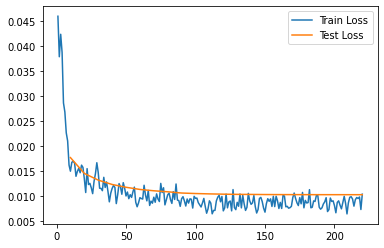

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 221 	Loss: 0.007541
Train Epoch: 221 	Loss: 0.010064
Train Epoch: 221 	Loss: 0.007521


Train Epoch: 222 	Loss: 0.006889
Train Epoch: 222 	Loss: 0.008919
Train Epoch: 222 	Loss: 0.008597


Train Epoch: 223 	Loss: 0.009285
Train Epoch: 223 	Loss: 0.008019
Train Epoch: 223 	Loss: 0.009325


Train Epoch: 224 	Loss: 0.008987
Train Epoch: 224 	Loss: 0.008311
Train Epoch: 224 	Loss: 0.007120


Train Epoch: 225 	Loss: 0.010375
Train Epoch: 225 	Loss: 0.006865
Train Epoch: 225 	Loss: 0.009954


Train Epoch: 226 	Loss: 0.008460
Train Epoch: 226 	Loss: 0.009142
Train Epoch: 226 	Loss: 0.007559


Train Epoch: 227 	Loss: 0.008468
Train Epoch: 227 	Loss: 0.006105
Train Epoch: 227 	Loss: 0.010804


Train Epoch: 228 	Loss: 0.007311
Train Epoch: 228 	Loss: 0.009281
Train Epoch: 228 	Loss: 0.009695


Train Epoch: 229 	Loss: 0.008913
Train Epoch: 229 	Loss: 0.009089
Train Epoch: 229 	Loss: 0.009442


Train Epoch: 230 	Loss: 0.007903
Train Epoch: 230 	Loss: 0.007896
Train Epoch: 230 	Loss: 0

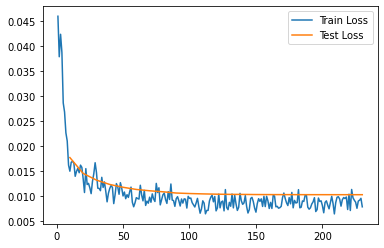

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 231 	Loss: 0.008388
Train Epoch: 231 	Loss: 0.008693
Train Epoch: 231 	Loss: 0.008476


Train Epoch: 232 	Loss: 0.009255
Train Epoch: 232 	Loss: 0.010081
Train Epoch: 232 	Loss: 0.006930


Train Epoch: 233 	Loss: 0.008673
Train Epoch: 233 	Loss: 0.007883
Train Epoch: 233 	Loss: 0.009142


Train Epoch: 234 	Loss: 0.009302
Train Epoch: 234 	Loss: 0.009334
Train Epoch: 234 	Loss: 0.007670


Train Epoch: 235 	Loss: 0.009872
Train Epoch: 235 	Loss: 0.008194
Train Epoch: 235 	Loss: 0.009095


Train Epoch: 236 	Loss: 0.008238
Train Epoch: 236 	Loss: 0.008157
Train Epoch: 236 	Loss: 0.009929


Train Epoch: 237 	Loss: 0.007518
Train Epoch: 237 	Loss: 0.008251
Train Epoch: 237 	Loss: 0.008336


Train Epoch: 238 	Loss: 0.007792
Train Epoch: 238 	Loss: 0.007729
Train Epoch: 238 	Loss: 0.010589


Train Epoch: 239 	Loss: 0.009191
Train Epoch: 239 	Loss: 0.008910
Train Epoch: 239 	Loss: 0.007553


Train Epoch: 240 	Loss: 0.008604
Train Epoch: 240 	Loss: 0.007567
Train Epoch: 240 	Loss: 0

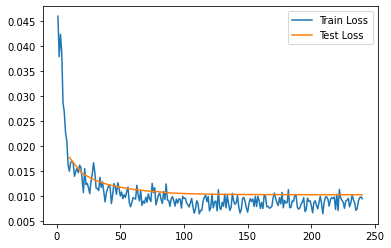

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 241 	Loss: 0.009261
Train Epoch: 241 	Loss: 0.008415
Train Epoch: 241 	Loss: 0.011861


Train Epoch: 242 	Loss: 0.007347
Train Epoch: 242 	Loss: 0.007400
Train Epoch: 242 	Loss: 0.008233


Train Epoch: 243 	Loss: 0.008873
Train Epoch: 243 	Loss: 0.008019
Train Epoch: 243 	Loss: 0.007846


Train Epoch: 244 	Loss: 0.007830
Train Epoch: 244 	Loss: 0.008192
Train Epoch: 244 	Loss: 0.008488


Train Epoch: 245 	Loss: 0.007755
Train Epoch: 245 	Loss: 0.008605
Train Epoch: 245 	Loss: 0.009244


Train Epoch: 246 	Loss: 0.006874
Train Epoch: 246 	Loss: 0.007386
Train Epoch: 246 	Loss: 0.008762


Train Epoch: 247 	Loss: 0.007902
Train Epoch: 247 	Loss: 0.007545
Train Epoch: 247 	Loss: 0.007868


Train Epoch: 248 	Loss: 0.006438
Train Epoch: 248 	Loss: 0.007706
Train Epoch: 248 	Loss: 0.008075


Train Epoch: 249 	Loss: 0.007133
Train Epoch: 249 	Loss: 0.009551
Train Epoch: 249 	Loss: 0.008379


Train Epoch: 250 	Loss: 0.007836
Train Epoch: 250 	Loss: 0.007207
Train Epoch: 250 	Loss: 0

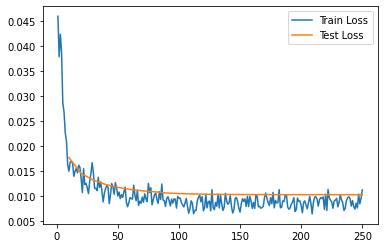

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 251 	Loss: 0.006894
Train Epoch: 251 	Loss: 0.006985
Train Epoch: 251 	Loss: 0.007338


Train Epoch: 252 	Loss: 0.008849
Train Epoch: 252 	Loss: 0.007988
Train Epoch: 252 	Loss: 0.007039


Train Epoch: 253 	Loss: 0.007769
Train Epoch: 253 	Loss: 0.009386
Train Epoch: 253 	Loss: 0.008040


Train Epoch: 254 	Loss: 0.008503
Train Epoch: 254 	Loss: 0.010000
Train Epoch: 254 	Loss: 0.007367


Train Epoch: 255 	Loss: 0.007220
Train Epoch: 255 	Loss: 0.008630
Train Epoch: 255 	Loss: 0.008311


Train Epoch: 256 	Loss: 0.008688
Train Epoch: 256 	Loss: 0.010416
Train Epoch: 256 	Loss: 0.008418


Train Epoch: 257 	Loss: 0.007501
Train Epoch: 257 	Loss: 0.008893
Train Epoch: 257 	Loss: 0.008314


Train Epoch: 258 	Loss: 0.009803
Train Epoch: 258 	Loss: 0.007520
Train Epoch: 258 	Loss: 0.007831


Train Epoch: 259 	Loss: 0.007052
Train Epoch: 259 	Loss: 0.008383
Train Epoch: 259 	Loss: 0.007366


Train Epoch: 260 	Loss: 0.008297
Train Epoch: 260 	Loss: 0.007846
Train Epoch: 260 	Loss: 0

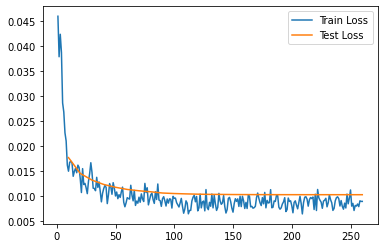

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 261 	Loss: 0.009276
Train Epoch: 261 	Loss: 0.010327
Train Epoch: 261 	Loss: 0.007077


Train Epoch: 262 	Loss: 0.008676
Train Epoch: 262 	Loss: 0.009448
Train Epoch: 262 	Loss: 0.008282


Train Epoch: 263 	Loss: 0.008310
Train Epoch: 263 	Loss: 0.009117
Train Epoch: 263 	Loss: 0.008281


Train Epoch: 264 	Loss: 0.008398
Train Epoch: 264 	Loss: 0.007274
Train Epoch: 264 	Loss: 0.005957


Train Epoch: 265 	Loss: 0.008240
Train Epoch: 265 	Loss: 0.008301
Train Epoch: 265 	Loss: 0.008317


Train Epoch: 266 	Loss: 0.007756
Train Epoch: 266 	Loss: 0.007006
Train Epoch: 266 	Loss: 0.009559


Train Epoch: 267 	Loss: 0.008643
Train Epoch: 267 	Loss: 0.006936
Train Epoch: 267 	Loss: 0.008490


Train Epoch: 268 	Loss: 0.009477
Train Epoch: 268 	Loss: 0.009522
Train Epoch: 268 	Loss: 0.008644


Train Epoch: 269 	Loss: 0.008170
Train Epoch: 269 	Loss: 0.007962
Train Epoch: 269 	Loss: 0.010102


Train Epoch: 270 	Loss: 0.010061
Train Epoch: 270 	Loss: 0.008488
Train Epoch: 270 	Loss: 0

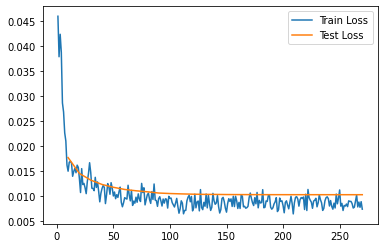

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 271 	Loss: 0.007118
Train Epoch: 271 	Loss: 0.007932
Train Epoch: 271 	Loss: 0.006570


Train Epoch: 272 	Loss: 0.007213
Train Epoch: 272 	Loss: 0.008616
Train Epoch: 272 	Loss: 0.009433


Train Epoch: 273 	Loss: 0.009330
Train Epoch: 273 	Loss: 0.007540
Train Epoch: 273 	Loss: 0.006957


Train Epoch: 274 	Loss: 0.010175
Train Epoch: 274 	Loss: 0.007269
Train Epoch: 274 	Loss: 0.008855


Train Epoch: 275 	Loss: 0.008606
Train Epoch: 275 	Loss: 0.007798
Train Epoch: 275 	Loss: 0.010083


Train Epoch: 276 	Loss: 0.008442
Train Epoch: 276 	Loss: 0.007634
Train Epoch: 276 	Loss: 0.008157


Train Epoch: 277 	Loss: 0.008676
Train Epoch: 277 	Loss: 0.008396
Train Epoch: 277 	Loss: 0.010237


Train Epoch: 278 	Loss: 0.007813
Train Epoch: 278 	Loss: 0.009485
Train Epoch: 278 	Loss: 0.009177


Train Epoch: 279 	Loss: 0.006030
Train Epoch: 279 	Loss: 0.010395
Train Epoch: 279 	Loss: 0.008324


Train Epoch: 280 	Loss: 0.007826
Train Epoch: 280 	Loss: 0.007471
Train Epoch: 280 	Loss: 0

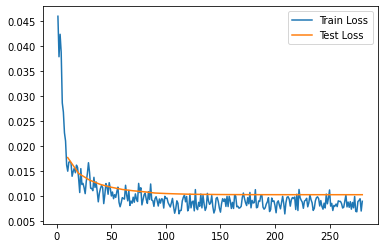

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 281 	Loss: 0.007415
Train Epoch: 281 	Loss: 0.007626
Train Epoch: 281 	Loss: 0.008258


Train Epoch: 282 	Loss: 0.008089
Train Epoch: 282 	Loss: 0.008885
Train Epoch: 282 	Loss: 0.006753


Train Epoch: 283 	Loss: 0.010978
Train Epoch: 283 	Loss: 0.006141
Train Epoch: 283 	Loss: 0.007642


Train Epoch: 284 	Loss: 0.009301
Train Epoch: 284 	Loss: 0.008040
Train Epoch: 284 	Loss: 0.009436


Train Epoch: 285 	Loss: 0.006986
Train Epoch: 285 	Loss: 0.008988
Train Epoch: 285 	Loss: 0.008916


Train Epoch: 286 	Loss: 0.008977
Train Epoch: 286 	Loss: 0.009969
Train Epoch: 286 	Loss: 0.008106


Train Epoch: 287 	Loss: 0.009779
Train Epoch: 287 	Loss: 0.009516
Train Epoch: 287 	Loss: 0.009173


Train Epoch: 288 	Loss: 0.007956
Train Epoch: 288 	Loss: 0.008609
Train Epoch: 288 	Loss: 0.008663


Train Epoch: 289 	Loss: 0.008107
Train Epoch: 289 	Loss: 0.008389
Train Epoch: 289 	Loss: 0.007314


Train Epoch: 290 	Loss: 0.006740
Train Epoch: 290 	Loss: 0.008479
Train Epoch: 290 	Loss: 0

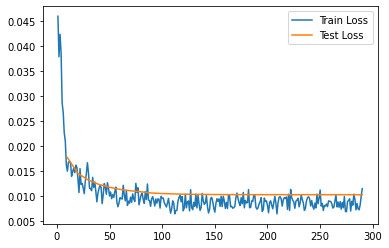

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 291 	Loss: 0.007760
Train Epoch: 291 	Loss: 0.008251
Train Epoch: 291 	Loss: 0.008487


Train Epoch: 292 	Loss: 0.007760
Train Epoch: 292 	Loss: 0.010784
Train Epoch: 292 	Loss: 0.008884


Train Epoch: 293 	Loss: 0.008403
Train Epoch: 293 	Loss: 0.007777
Train Epoch: 293 	Loss: 0.010954


Train Epoch: 294 	Loss: 0.009783
Train Epoch: 294 	Loss: 0.009691
Train Epoch: 294 	Loss: 0.011673


Train Epoch: 295 	Loss: 0.009408
Train Epoch: 295 	Loss: 0.008890
Train Epoch: 295 	Loss: 0.008852


Train Epoch: 296 	Loss: 0.008758
Train Epoch: 296 	Loss: 0.007700
Train Epoch: 296 	Loss: 0.008341


Train Epoch: 297 	Loss: 0.008429
Train Epoch: 297 	Loss: 0.007279
Train Epoch: 297 	Loss: 0.006866


Train Epoch: 298 	Loss: 0.009179
Train Epoch: 298 	Loss: 0.009821
Train Epoch: 298 	Loss: 0.009300


Train Epoch: 299 	Loss: 0.010320
Train Epoch: 299 	Loss: 0.006462
Train Epoch: 299 	Loss: 0.008223


Train Epoch: 300 	Loss: 0.009032
Train Epoch: 300 	Loss: 0.008346
Train Epoch: 300 	Loss: 0

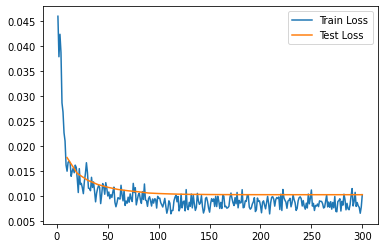

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 301 	Loss: 0.009263
Train Epoch: 301 	Loss: 0.009307
Train Epoch: 301 	Loss: 0.008321


Train Epoch: 302 	Loss: 0.008928
Train Epoch: 302 	Loss: 0.006645
Train Epoch: 302 	Loss: 0.008029


Train Epoch: 303 	Loss: 0.010167
Train Epoch: 303 	Loss: 0.007549
Train Epoch: 303 	Loss: 0.009341


Train Epoch: 304 	Loss: 0.008212
Train Epoch: 304 	Loss: 0.009154
Train Epoch: 304 	Loss: 0.009848


Train Epoch: 305 	Loss: 0.010198
Train Epoch: 305 	Loss: 0.010635
Train Epoch: 305 	Loss: 0.007860


Train Epoch: 306 	Loss: 0.007308
Train Epoch: 306 	Loss: 0.007116
Train Epoch: 306 	Loss: 0.008961


Train Epoch: 307 	Loss: 0.009700
Train Epoch: 307 	Loss: 0.008069
Train Epoch: 307 	Loss: 0.007657


Train Epoch: 308 	Loss: 0.007424
Train Epoch: 308 	Loss: 0.009757
Train Epoch: 308 	Loss: 0.009872


Train Epoch: 309 	Loss: 0.008877
Train Epoch: 309 	Loss: 0.008373
Train Epoch: 309 	Loss: 0.010024


Train Epoch: 310 	Loss: 0.008412
Train Epoch: 310 	Loss: 0.008767
Train Epoch: 310 	Loss: 0

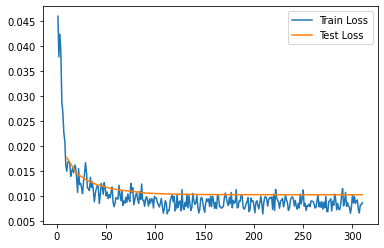

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 311 	Loss: 0.009686
Train Epoch: 311 	Loss: 0.009792
Train Epoch: 311 	Loss: 0.007408


Train Epoch: 312 	Loss: 0.006933
Train Epoch: 312 	Loss: 0.007901
Train Epoch: 312 	Loss: 0.009162


Train Epoch: 313 	Loss: 0.007795
Train Epoch: 313 	Loss: 0.008177
Train Epoch: 313 	Loss: 0.009602


Train Epoch: 314 	Loss: 0.008649
Train Epoch: 314 	Loss: 0.007488
Train Epoch: 314 	Loss: 0.008271


Train Epoch: 315 	Loss: 0.007657
Train Epoch: 315 	Loss: 0.009874
Train Epoch: 315 	Loss: 0.010000


Train Epoch: 316 	Loss: 0.009530
Train Epoch: 316 	Loss: 0.008223
Train Epoch: 316 	Loss: 0.007254


Train Epoch: 317 	Loss: 0.007729
Train Epoch: 317 	Loss: 0.007790
Train Epoch: 317 	Loss: 0.010384


Train Epoch: 318 	Loss: 0.007692
Train Epoch: 318 	Loss: 0.007531
Train Epoch: 318 	Loss: 0.008379


Train Epoch: 319 	Loss: 0.009069
Train Epoch: 319 	Loss: 0.008258
Train Epoch: 319 	Loss: 0.007119


Train Epoch: 320 	Loss: 0.006597
Train Epoch: 320 	Loss: 0.008188
Train Epoch: 320 	Loss: 0

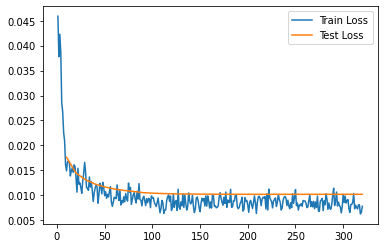

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 321 	Loss: 0.007234
Train Epoch: 321 	Loss: 0.009656
Train Epoch: 321 	Loss: 0.007977


Train Epoch: 322 	Loss: 0.008205
Train Epoch: 322 	Loss: 0.008975
Train Epoch: 322 	Loss: 0.009434


Train Epoch: 323 	Loss: 0.007050
Train Epoch: 323 	Loss: 0.008480
Train Epoch: 323 	Loss: 0.008012


Train Epoch: 324 	Loss: 0.010122
Train Epoch: 324 	Loss: 0.007176
Train Epoch: 324 	Loss: 0.009581


Train Epoch: 325 	Loss: 0.009077
Train Epoch: 325 	Loss: 0.007483
Train Epoch: 325 	Loss: 0.010655


Train Epoch: 326 	Loss: 0.008183
Train Epoch: 326 	Loss: 0.006795
Train Epoch: 326 	Loss: 0.008661


Train Epoch: 327 	Loss: 0.008745
Train Epoch: 327 	Loss: 0.008091
Train Epoch: 327 	Loss: 0.007606


Train Epoch: 328 	Loss: 0.008920
Train Epoch: 328 	Loss: 0.008109
Train Epoch: 328 	Loss: 0.008296


Train Epoch: 329 	Loss: 0.007717
Train Epoch: 329 	Loss: 0.007712
Train Epoch: 329 	Loss: 0.010063


Train Epoch: 330 	Loss: 0.007599
Train Epoch: 330 	Loss: 0.008235
Train Epoch: 330 	Loss: 0

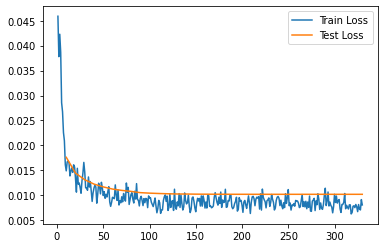

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 331 	Loss: 0.006339
Train Epoch: 331 	Loss: 0.008673
Train Epoch: 331 	Loss: 0.007753


Train Epoch: 332 	Loss: 0.008552
Train Epoch: 332 	Loss: 0.007979
Train Epoch: 332 	Loss: 0.007783


Train Epoch: 333 	Loss: 0.007649
Train Epoch: 333 	Loss: 0.008744
Train Epoch: 333 	Loss: 0.008329


Train Epoch: 334 	Loss: 0.007356
Train Epoch: 334 	Loss: 0.009033
Train Epoch: 334 	Loss: 0.011044


Train Epoch: 335 	Loss: 0.007921
Train Epoch: 335 	Loss: 0.007517
Train Epoch: 335 	Loss: 0.009037


Train Epoch: 336 	Loss: 0.008145
Train Epoch: 336 	Loss: 0.007799
Train Epoch: 336 	Loss: 0.006884


Train Epoch: 337 	Loss: 0.009177
Train Epoch: 337 	Loss: 0.009510
Train Epoch: 337 	Loss: 0.008271


Train Epoch: 338 	Loss: 0.009850
Train Epoch: 338 	Loss: 0.007637
Train Epoch: 338 	Loss: 0.008938


Train Epoch: 339 	Loss: 0.008631
Train Epoch: 339 	Loss: 0.009981
Train Epoch: 339 	Loss: 0.007903


Train Epoch: 340 	Loss: 0.010333
Train Epoch: 340 	Loss: 0.009367
Train Epoch: 340 	Loss: 0

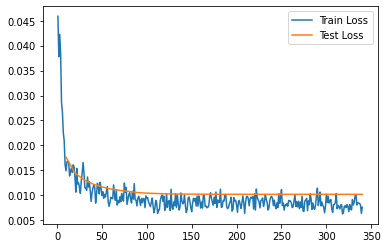

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 341 	Loss: 0.007148
Train Epoch: 341 	Loss: 0.010346
Train Epoch: 341 	Loss: 0.008037


Train Epoch: 342 	Loss: 0.006636
Train Epoch: 342 	Loss: 0.009852
Train Epoch: 342 	Loss: 0.008799


Train Epoch: 343 	Loss: 0.008498
Train Epoch: 343 	Loss: 0.007646
Train Epoch: 343 	Loss: 0.009376


Train Epoch: 344 	Loss: 0.009126
Train Epoch: 344 	Loss: 0.007710
Train Epoch: 344 	Loss: 0.007482


Train Epoch: 345 	Loss: 0.009485
Train Epoch: 345 	Loss: 0.008741
Train Epoch: 345 	Loss: 0.009131


Train Epoch: 346 	Loss: 0.008174
Train Epoch: 346 	Loss: 0.008848
Train Epoch: 346 	Loss: 0.007747


Train Epoch: 347 	Loss: 0.008748
Train Epoch: 347 	Loss: 0.009632
Train Epoch: 347 	Loss: 0.009396


Train Epoch: 348 	Loss: 0.007649
Train Epoch: 348 	Loss: 0.009860
Train Epoch: 348 	Loss: 0.007712


Train Epoch: 349 	Loss: 0.008704
Train Epoch: 349 	Loss: 0.009470
Train Epoch: 349 	Loss: 0.009580


Train Epoch: 350 	Loss: 0.007411
Train Epoch: 350 	Loss: 0.008158
Train Epoch: 350 	Loss: 0

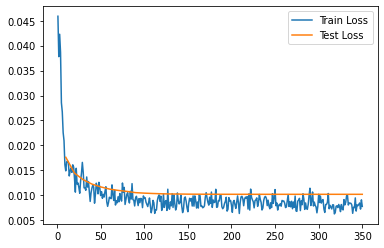

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 351 	Loss: 0.009324
Train Epoch: 351 	Loss: 0.007289
Train Epoch: 351 	Loss: 0.008133


Train Epoch: 352 	Loss: 0.008910
Train Epoch: 352 	Loss: 0.008694
Train Epoch: 352 	Loss: 0.007171


Train Epoch: 353 	Loss: 0.009902
Train Epoch: 353 	Loss: 0.007415
Train Epoch: 353 	Loss: 0.010036


Train Epoch: 354 	Loss: 0.007831
Train Epoch: 354 	Loss: 0.009890
Train Epoch: 354 	Loss: 0.008218


Train Epoch: 355 	Loss: 0.009952
Train Epoch: 355 	Loss: 0.008815
Train Epoch: 355 	Loss: 0.007080


Train Epoch: 356 	Loss: 0.008106
Train Epoch: 356 	Loss: 0.009518
Train Epoch: 356 	Loss: 0.009197


Train Epoch: 357 	Loss: 0.008628
Train Epoch: 357 	Loss: 0.007943
Train Epoch: 357 	Loss: 0.008123


Train Epoch: 358 	Loss: 0.009629
Train Epoch: 358 	Loss: 0.008305
Train Epoch: 358 	Loss: 0.008878


Train Epoch: 359 	Loss: 0.009667
Train Epoch: 359 	Loss: 0.008228
Train Epoch: 359 	Loss: 0.009740


Train Epoch: 360 	Loss: 0.008193
Train Epoch: 360 	Loss: 0.007849
Train Epoch: 360 	Loss: 0

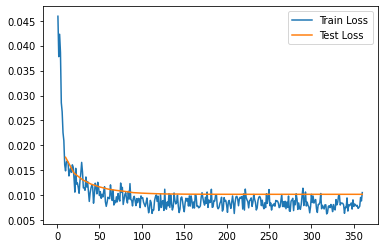

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 361 	Loss: 0.007591
Train Epoch: 361 	Loss: 0.009139
Train Epoch: 361 	Loss: 0.010354


Train Epoch: 362 	Loss: 0.006444
Train Epoch: 362 	Loss: 0.010169
Train Epoch: 362 	Loss: 0.008283


Train Epoch: 363 	Loss: 0.007354
Train Epoch: 363 	Loss: 0.008327
Train Epoch: 363 	Loss: 0.009137


Train Epoch: 364 	Loss: 0.009672
Train Epoch: 364 	Loss: 0.009815
Train Epoch: 364 	Loss: 0.007154


Train Epoch: 365 	Loss: 0.009628
Train Epoch: 365 	Loss: 0.008022
Train Epoch: 365 	Loss: 0.009535


Train Epoch: 366 	Loss: 0.008794
Train Epoch: 366 	Loss: 0.009408
Train Epoch: 366 	Loss: 0.007523


Train Epoch: 367 	Loss: 0.008522
Train Epoch: 367 	Loss: 0.006974
Train Epoch: 367 	Loss: 0.007935


Train Epoch: 368 	Loss: 0.007592
Train Epoch: 368 	Loss: 0.009577
Train Epoch: 368 	Loss: 0.008545


Train Epoch: 369 	Loss: 0.008519
Train Epoch: 369 	Loss: 0.009194
Train Epoch: 369 	Loss: 0.010026


Train Epoch: 370 	Loss: 0.008324
Train Epoch: 370 	Loss: 0.010300
Train Epoch: 370 	Loss: 0

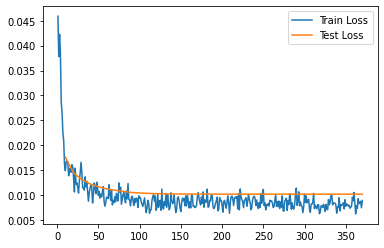

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 371 	Loss: 0.007091
Train Epoch: 371 	Loss: 0.007561
Train Epoch: 371 	Loss: 0.010009


Train Epoch: 372 	Loss: 0.008042
Train Epoch: 372 	Loss: 0.008290
Train Epoch: 372 	Loss: 0.008681


Train Epoch: 373 	Loss: 0.008527
Train Epoch: 373 	Loss: 0.009124
Train Epoch: 373 	Loss: 0.008079


Train Epoch: 374 	Loss: 0.008175
Train Epoch: 374 	Loss: 0.008048
Train Epoch: 374 	Loss: 0.007262


Train Epoch: 375 	Loss: 0.009521
Train Epoch: 375 	Loss: 0.008715
Train Epoch: 375 	Loss: 0.009229


Train Epoch: 376 	Loss: 0.008703
Train Epoch: 376 	Loss: 0.007829
Train Epoch: 376 	Loss: 0.007838


Train Epoch: 377 	Loss: 0.011640
Train Epoch: 377 	Loss: 0.008975
Train Epoch: 377 	Loss: 0.009688


Train Epoch: 378 	Loss: 0.007546
Train Epoch: 378 	Loss: 0.008830
Train Epoch: 378 	Loss: 0.009778


Train Epoch: 379 	Loss: 0.007326
Train Epoch: 379 	Loss: 0.009127
Train Epoch: 379 	Loss: 0.007294


Train Epoch: 380 	Loss: 0.007431
Train Epoch: 380 	Loss: 0.008531
Train Epoch: 380 	Loss: 0

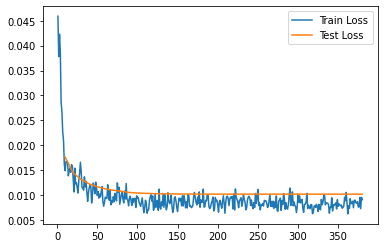

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 381 	Loss: 0.008717
Train Epoch: 381 	Loss: 0.007889
Train Epoch: 381 	Loss: 0.007873


Train Epoch: 382 	Loss: 0.008746
Train Epoch: 382 	Loss: 0.007995
Train Epoch: 382 	Loss: 0.008841


Train Epoch: 383 	Loss: 0.009408
Train Epoch: 383 	Loss: 0.008973
Train Epoch: 383 	Loss: 0.007874


Train Epoch: 384 	Loss: 0.008921
Train Epoch: 384 	Loss: 0.008568
Train Epoch: 384 	Loss: 0.008853


Train Epoch: 385 	Loss: 0.008383
Train Epoch: 385 	Loss: 0.008406
Train Epoch: 385 	Loss: 0.010841


Train Epoch: 386 	Loss: 0.009025
Train Epoch: 386 	Loss: 0.009128
Train Epoch: 386 	Loss: 0.010002


Train Epoch: 387 	Loss: 0.007213
Train Epoch: 387 	Loss: 0.007214
Train Epoch: 387 	Loss: 0.007749


Train Epoch: 388 	Loss: 0.008186
Train Epoch: 388 	Loss: 0.006861
Train Epoch: 388 	Loss: 0.008969


Train Epoch: 389 	Loss: 0.007408
Train Epoch: 389 	Loss: 0.009537
Train Epoch: 389 	Loss: 0.007753


Train Epoch: 390 	Loss: 0.009712
Train Epoch: 390 	Loss: 0.008691
Train Epoch: 390 	Loss: 0

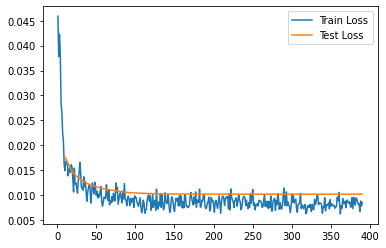

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 391 	Loss: 0.008102
Train Epoch: 391 	Loss: 0.008231
Train Epoch: 391 	Loss: 0.007674


Train Epoch: 392 	Loss: 0.008469
Train Epoch: 392 	Loss: 0.010355
Train Epoch: 392 	Loss: 0.007032


Train Epoch: 393 	Loss: 0.008792
Train Epoch: 393 	Loss: 0.007986
Train Epoch: 393 	Loss: 0.009013


Train Epoch: 394 	Loss: 0.006642
Train Epoch: 394 	Loss: 0.010272
Train Epoch: 394 	Loss: 0.009160


Train Epoch: 395 	Loss: 0.010329
Train Epoch: 395 	Loss: 0.008381
Train Epoch: 395 	Loss: 0.008785


Train Epoch: 396 	Loss: 0.009708
Train Epoch: 396 	Loss: 0.009782
Train Epoch: 396 	Loss: 0.008513


Train Epoch: 397 	Loss: 0.008610
Train Epoch: 397 	Loss: 0.009250
Train Epoch: 397 	Loss: 0.007346


Train Epoch: 398 	Loss: 0.007081
Train Epoch: 398 	Loss: 0.008336
Train Epoch: 398 	Loss: 0.008638


Train Epoch: 399 	Loss: 0.007542
Train Epoch: 399 	Loss: 0.009275
Train Epoch: 399 	Loss: 0.008139


Train Epoch: 400 	Loss: 0.007851
Train Epoch: 400 	Loss: 0.008552
Train Epoch: 400 	Loss: 0

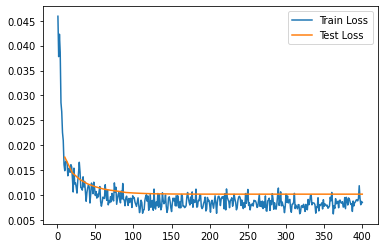

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 401 	Loss: 0.006772
Train Epoch: 401 	Loss: 0.008407
Train Epoch: 401 	Loss: 0.006382


Train Epoch: 402 	Loss: 0.006504
Train Epoch: 402 	Loss: 0.010326
Train Epoch: 402 	Loss: 0.006198


Train Epoch: 403 	Loss: 0.008216
Train Epoch: 403 	Loss: 0.006971
Train Epoch: 403 	Loss: 0.009271


Train Epoch: 404 	Loss: 0.008517
Train Epoch: 404 	Loss: 0.007918
Train Epoch: 404 	Loss: 0.006610


Train Epoch: 405 	Loss: 0.008405
Train Epoch: 405 	Loss: 0.008278
Train Epoch: 405 	Loss: 0.006208


Train Epoch: 406 	Loss: 0.007719
Train Epoch: 406 	Loss: 0.008133
Train Epoch: 406 	Loss: 0.008143


Train Epoch: 407 	Loss: 0.008335
Train Epoch: 407 	Loss: 0.008692
Train Epoch: 407 	Loss: 0.008307


Train Epoch: 408 	Loss: 0.010442
Train Epoch: 408 	Loss: 0.009566
Train Epoch: 408 	Loss: 0.006643


Train Epoch: 409 	Loss: 0.006874
Train Epoch: 409 	Loss: 0.007454
Train Epoch: 409 	Loss: 0.008783


Train Epoch: 410 	Loss: 0.010312
Train Epoch: 410 	Loss: 0.007858
Train Epoch: 410 	Loss: 0

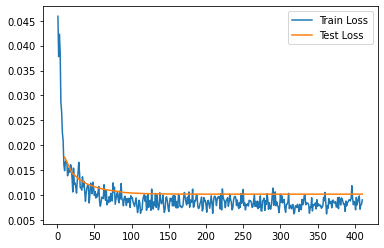

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 411 	Loss: 0.008328
Train Epoch: 411 	Loss: 0.008899
Train Epoch: 411 	Loss: 0.006235


Train Epoch: 412 	Loss: 0.007360
Train Epoch: 412 	Loss: 0.008346
Train Epoch: 412 	Loss: 0.011203


Train Epoch: 413 	Loss: 0.007079
Train Epoch: 413 	Loss: 0.008994
Train Epoch: 413 	Loss: 0.008560


Train Epoch: 414 	Loss: 0.007478
Train Epoch: 414 	Loss: 0.007781
Train Epoch: 414 	Loss: 0.009550


Train Epoch: 415 	Loss: 0.008547
Train Epoch: 415 	Loss: 0.010599
Train Epoch: 415 	Loss: 0.008990


Train Epoch: 416 	Loss: 0.007654
Train Epoch: 416 	Loss: 0.009866
Train Epoch: 416 	Loss: 0.007235


Train Epoch: 417 	Loss: 0.010570
Train Epoch: 417 	Loss: 0.008944
Train Epoch: 417 	Loss: 0.006567


Train Epoch: 418 	Loss: 0.009254
Train Epoch: 418 	Loss: 0.009152
Train Epoch: 418 	Loss: 0.007245


Train Epoch: 419 	Loss: 0.008715
Train Epoch: 419 	Loss: 0.008273
Train Epoch: 419 	Loss: 0.008342


Train Epoch: 420 	Loss: 0.007073
Train Epoch: 420 	Loss: 0.007620
Train Epoch: 420 	Loss: 0

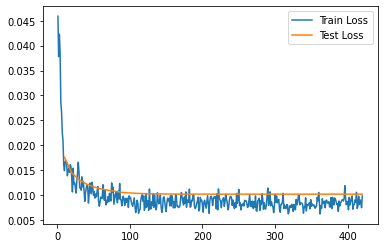

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 421 	Loss: 0.009315
Train Epoch: 421 	Loss: 0.009092
Train Epoch: 421 	Loss: 0.006784


Train Epoch: 422 	Loss: 0.006761
Train Epoch: 422 	Loss: 0.007505
Train Epoch: 422 	Loss: 0.008967


Train Epoch: 423 	Loss: 0.008975
Train Epoch: 423 	Loss: 0.009938
Train Epoch: 423 	Loss: 0.008499


Train Epoch: 424 	Loss: 0.008609
Train Epoch: 424 	Loss: 0.008669
Train Epoch: 424 	Loss: 0.006966


Train Epoch: 425 	Loss: 0.009809
Train Epoch: 425 	Loss: 0.008963
Train Epoch: 425 	Loss: 0.008390


Train Epoch: 426 	Loss: 0.007308
Train Epoch: 426 	Loss: 0.007366
Train Epoch: 426 	Loss: 0.009251


Train Epoch: 427 	Loss: 0.008855
Train Epoch: 427 	Loss: 0.008011
Train Epoch: 427 	Loss: 0.008156


Train Epoch: 428 	Loss: 0.008171
Train Epoch: 428 	Loss: 0.008908
Train Epoch: 428 	Loss: 0.009706


Train Epoch: 429 	Loss: 0.008894
Train Epoch: 429 	Loss: 0.007799
Train Epoch: 429 	Loss: 0.009332


Train Epoch: 430 	Loss: 0.009155
Train Epoch: 430 	Loss: 0.009213
Train Epoch: 430 	Loss: 0

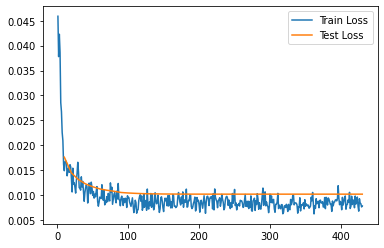

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 431 	Loss: 0.009795
Train Epoch: 431 	Loss: 0.007981
Train Epoch: 431 	Loss: 0.007209


Train Epoch: 432 	Loss: 0.007212
Train Epoch: 432 	Loss: 0.010247
Train Epoch: 432 	Loss: 0.007885


Train Epoch: 433 	Loss: 0.008642
Train Epoch: 433 	Loss: 0.007737
Train Epoch: 433 	Loss: 0.009462


Train Epoch: 434 	Loss: 0.008649
Train Epoch: 434 	Loss: 0.007940
Train Epoch: 434 	Loss: 0.008213


Train Epoch: 435 	Loss: 0.008448
Train Epoch: 435 	Loss: 0.008495
Train Epoch: 435 	Loss: 0.007657


Train Epoch: 436 	Loss: 0.008993
Train Epoch: 436 	Loss: 0.009298
Train Epoch: 436 	Loss: 0.007112


Train Epoch: 437 	Loss: 0.009736
Train Epoch: 437 	Loss: 0.009170
Train Epoch: 437 	Loss: 0.008389


Train Epoch: 438 	Loss: 0.008767
Train Epoch: 438 	Loss: 0.009078
Train Epoch: 438 	Loss: 0.008656


Train Epoch: 439 	Loss: 0.010953
Train Epoch: 439 	Loss: 0.008432
Train Epoch: 439 	Loss: 0.007163


Train Epoch: 440 	Loss: 0.006474
Train Epoch: 440 	Loss: 0.008868
Train Epoch: 440 	Loss: 0

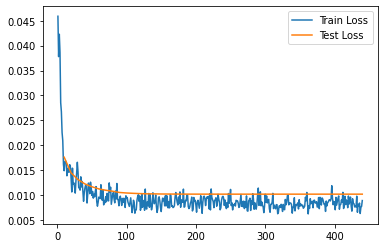

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 441 	Loss: 0.007724
Train Epoch: 441 	Loss: 0.008955
Train Epoch: 441 	Loss: 0.009106


Train Epoch: 442 	Loss: 0.008606
Train Epoch: 442 	Loss: 0.009719
Train Epoch: 442 	Loss: 0.008729


Train Epoch: 443 	Loss: 0.006959
Train Epoch: 443 	Loss: 0.009142
Train Epoch: 443 	Loss: 0.007013


Train Epoch: 444 	Loss: 0.007043
Train Epoch: 444 	Loss: 0.009945
Train Epoch: 444 	Loss: 0.008368


Train Epoch: 445 	Loss: 0.007364
Train Epoch: 445 	Loss: 0.009128
Train Epoch: 445 	Loss: 0.009861


Train Epoch: 446 	Loss: 0.008907
Train Epoch: 446 	Loss: 0.010441
Train Epoch: 446 	Loss: 0.007694


Train Epoch: 447 	Loss: 0.009205
Train Epoch: 447 	Loss: 0.007962
Train Epoch: 447 	Loss: 0.008507


Train Epoch: 448 	Loss: 0.008227
Train Epoch: 448 	Loss: 0.008384
Train Epoch: 448 	Loss: 0.008625


Train Epoch: 449 	Loss: 0.007924
Train Epoch: 449 	Loss: 0.009529
Train Epoch: 449 	Loss: 0.008456


Train Epoch: 450 	Loss: 0.006882
Train Epoch: 450 	Loss: 0.008353
Train Epoch: 450 	Loss: 0

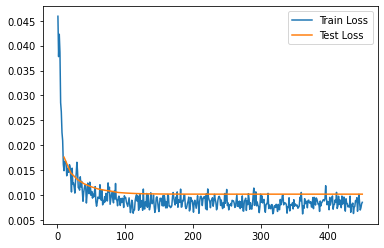

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 451 	Loss: 0.008100
Train Epoch: 451 	Loss: 0.008592
Train Epoch: 451 	Loss: 0.009606


Train Epoch: 452 	Loss: 0.007692
Train Epoch: 452 	Loss: 0.008163
Train Epoch: 452 	Loss: 0.008306


Train Epoch: 453 	Loss: 0.008196
Train Epoch: 453 	Loss: 0.010536
Train Epoch: 453 	Loss: 0.007720


Train Epoch: 454 	Loss: 0.009050
Train Epoch: 454 	Loss: 0.006972
Train Epoch: 454 	Loss: 0.008233


Train Epoch: 455 	Loss: 0.009902
Train Epoch: 455 	Loss: 0.008843
Train Epoch: 455 	Loss: 0.009249


Train Epoch: 456 	Loss: 0.008012
Train Epoch: 456 	Loss: 0.007416
Train Epoch: 456 	Loss: 0.007328


Train Epoch: 457 	Loss: 0.010396
Train Epoch: 457 	Loss: 0.010383
Train Epoch: 457 	Loss: 0.008640


Train Epoch: 458 	Loss: 0.008895
Train Epoch: 458 	Loss: 0.007990
Train Epoch: 458 	Loss: 0.008486


Train Epoch: 459 	Loss: 0.007648
Train Epoch: 459 	Loss: 0.006949
Train Epoch: 459 	Loss: 0.009638


Train Epoch: 460 	Loss: 0.009828
Train Epoch: 460 	Loss: 0.008060
Train Epoch: 460 	Loss: 0

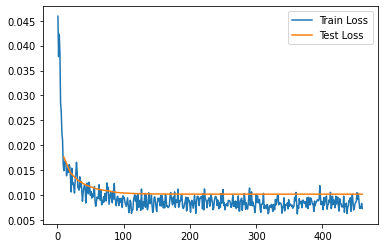

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 461 	Loss: 0.006917
Train Epoch: 461 	Loss: 0.008146
Train Epoch: 461 	Loss: 0.008090


Train Epoch: 462 	Loss: 0.010106
Train Epoch: 462 	Loss: 0.009782
Train Epoch: 462 	Loss: 0.007698


Train Epoch: 463 	Loss: 0.008359
Train Epoch: 463 	Loss: 0.006956
Train Epoch: 463 	Loss: 0.010312


Train Epoch: 464 	Loss: 0.008071
Train Epoch: 464 	Loss: 0.008440
Train Epoch: 464 	Loss: 0.009832


Train Epoch: 465 	Loss: 0.009730
Train Epoch: 465 	Loss: 0.007710
Train Epoch: 465 	Loss: 0.008330


Train Epoch: 466 	Loss: 0.007150
Train Epoch: 466 	Loss: 0.009424
Train Epoch: 466 	Loss: 0.011225


Train Epoch: 467 	Loss: 0.008955
Train Epoch: 467 	Loss: 0.008411
Train Epoch: 467 	Loss: 0.009715


Train Epoch: 468 	Loss: 0.006668
Train Epoch: 468 	Loss: 0.008975
Train Epoch: 468 	Loss: 0.009030


Train Epoch: 469 	Loss: 0.010097
Train Epoch: 469 	Loss: 0.007973
Train Epoch: 469 	Loss: 0.009173


Train Epoch: 470 	Loss: 0.008158
Train Epoch: 470 	Loss: 0.007931
Train Epoch: 470 	Loss: 0

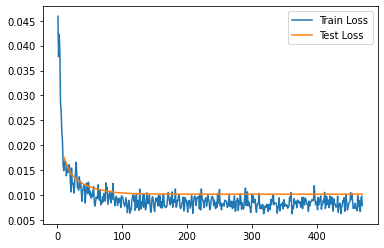

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 471 	Loss: 0.008195
Train Epoch: 471 	Loss: 0.006902
Train Epoch: 471 	Loss: 0.008412


Train Epoch: 472 	Loss: 0.006801
Train Epoch: 472 	Loss: 0.008356
Train Epoch: 472 	Loss: 0.007182


Train Epoch: 473 	Loss: 0.007525
Train Epoch: 473 	Loss: 0.007471
Train Epoch: 473 	Loss: 0.008896


Train Epoch: 474 	Loss: 0.008666
Train Epoch: 474 	Loss: 0.008460
Train Epoch: 474 	Loss: 0.007788


Train Epoch: 475 	Loss: 0.007394
Train Epoch: 475 	Loss: 0.010100
Train Epoch: 475 	Loss: 0.010024


Train Epoch: 476 	Loss: 0.007896
Train Epoch: 476 	Loss: 0.008757
Train Epoch: 476 	Loss: 0.009029


Train Epoch: 477 	Loss: 0.009092
Train Epoch: 477 	Loss: 0.007417
Train Epoch: 477 	Loss: 0.008567


Train Epoch: 478 	Loss: 0.010075
Train Epoch: 478 	Loss: 0.008856
Train Epoch: 478 	Loss: 0.010318


Train Epoch: 479 	Loss: 0.008289
Train Epoch: 479 	Loss: 0.007886
Train Epoch: 479 	Loss: 0.010476


Train Epoch: 480 	Loss: 0.009292
Train Epoch: 480 	Loss: 0.009618
Train Epoch: 480 	Loss: 0

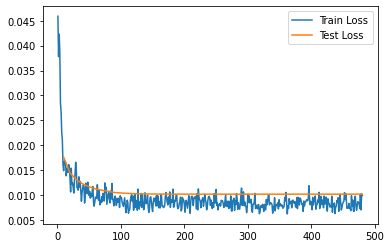

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 481 	Loss: 0.010019
Train Epoch: 481 	Loss: 0.009395
Train Epoch: 481 	Loss: 0.008753


Train Epoch: 482 	Loss: 0.009079
Train Epoch: 482 	Loss: 0.009888
Train Epoch: 482 	Loss: 0.007388


Train Epoch: 483 	Loss: 0.008774
Train Epoch: 483 	Loss: 0.009058
Train Epoch: 483 	Loss: 0.009777


Train Epoch: 484 	Loss: 0.007838
Train Epoch: 484 	Loss: 0.009813
Train Epoch: 484 	Loss: 0.007013


Train Epoch: 485 	Loss: 0.006634
Train Epoch: 485 	Loss: 0.008302
Train Epoch: 485 	Loss: 0.008619


Train Epoch: 486 	Loss: 0.008220
Train Epoch: 486 	Loss: 0.008777
Train Epoch: 486 	Loss: 0.009529


Train Epoch: 487 	Loss: 0.007291
Train Epoch: 487 	Loss: 0.009493
Train Epoch: 487 	Loss: 0.008155


Train Epoch: 488 	Loss: 0.009262
Train Epoch: 488 	Loss: 0.009449
Train Epoch: 488 	Loss: 0.011341


Train Epoch: 489 	Loss: 0.009709
Train Epoch: 489 	Loss: 0.008677
Train Epoch: 489 	Loss: 0.007359


Train Epoch: 490 	Loss: 0.007648
Train Epoch: 490 	Loss: 0.008619
Train Epoch: 490 	Loss: 0

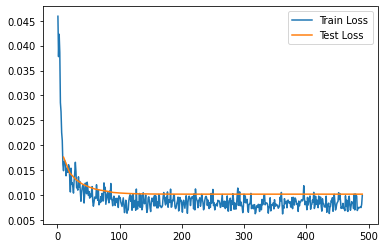

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 491 	Loss: 0.007855
Train Epoch: 491 	Loss: 0.008810
Train Epoch: 491 	Loss: 0.007901


Train Epoch: 492 	Loss: 0.009574
Train Epoch: 492 	Loss: 0.008563
Train Epoch: 492 	Loss: 0.008925


Train Epoch: 493 	Loss: 0.007877
Train Epoch: 493 	Loss: 0.009847
Train Epoch: 493 	Loss: 0.007061


Train Epoch: 494 	Loss: 0.007030
Train Epoch: 494 	Loss: 0.007753
Train Epoch: 494 	Loss: 0.012196


Train Epoch: 495 	Loss: 0.009389
Train Epoch: 495 	Loss: 0.008076
Train Epoch: 495 	Loss: 0.009178


Train Epoch: 496 	Loss: 0.009065
Train Epoch: 496 	Loss: 0.007529
Train Epoch: 496 	Loss: 0.008024


Train Epoch: 497 	Loss: 0.007750
Train Epoch: 497 	Loss: 0.008612
Train Epoch: 497 	Loss: 0.008182


Train Epoch: 498 	Loss: 0.009750
Train Epoch: 498 	Loss: 0.009389
Train Epoch: 498 	Loss: 0.007626


Train Epoch: 499 	Loss: 0.007851
Train Epoch: 499 	Loss: 0.006811
Train Epoch: 499 	Loss: 0.008773


Train Epoch: 500 	Loss: 0.006775
Train Epoch: 500 	Loss: 0.010164
Train Epoch: 500 	Loss: 0

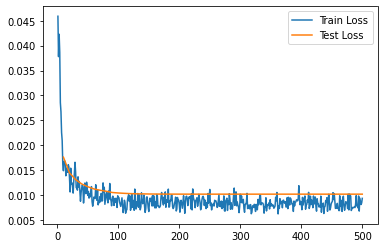

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 501 	Loss: 0.008677
Train Epoch: 501 	Loss: 0.007454
Train Epoch: 501 	Loss: 0.007563


Train Epoch: 502 	Loss: 0.009099
Train Epoch: 502 	Loss: 0.008977
Train Epoch: 502 	Loss: 0.008053


Train Epoch: 503 	Loss: 0.008408
Train Epoch: 503 	Loss: 0.010165
Train Epoch: 503 	Loss: 0.010667


Train Epoch: 504 	Loss: 0.007806
Train Epoch: 504 	Loss: 0.008925
Train Epoch: 504 	Loss: 0.009756


Train Epoch: 505 	Loss: 0.007779
Train Epoch: 505 	Loss: 0.007835
Train Epoch: 505 	Loss: 0.008430


Train Epoch: 506 	Loss: 0.007580
Train Epoch: 506 	Loss: 0.007236
Train Epoch: 506 	Loss: 0.008651


Train Epoch: 507 	Loss: 0.009500
Train Epoch: 507 	Loss: 0.006132
Train Epoch: 507 	Loss: 0.009425


Train Epoch: 508 	Loss: 0.010216
Train Epoch: 508 	Loss: 0.006512
Train Epoch: 508 	Loss: 0.007655


Train Epoch: 509 	Loss: 0.007384
Train Epoch: 509 	Loss: 0.008714
Train Epoch: 509 	Loss: 0.007348


Train Epoch: 510 	Loss: 0.007516
Train Epoch: 510 	Loss: 0.010819
Train Epoch: 510 	Loss: 0

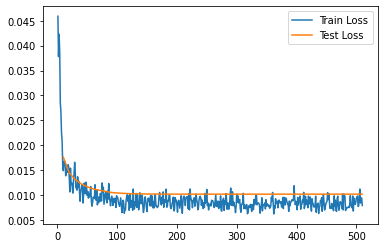

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 511 	Loss: 0.006841
Train Epoch: 511 	Loss: 0.008167
Train Epoch: 511 	Loss: 0.006954


Train Epoch: 512 	Loss: 0.009519
Train Epoch: 512 	Loss: 0.006143
Train Epoch: 512 	Loss: 0.006882


Train Epoch: 513 	Loss: 0.009949
Train Epoch: 513 	Loss: 0.009000
Train Epoch: 513 	Loss: 0.009801


Train Epoch: 514 	Loss: 0.007208
Train Epoch: 514 	Loss: 0.010550
Train Epoch: 514 	Loss: 0.008870


Train Epoch: 515 	Loss: 0.007098
Train Epoch: 515 	Loss: 0.009498
Train Epoch: 515 	Loss: 0.007466


Train Epoch: 516 	Loss: 0.008416
Train Epoch: 516 	Loss: 0.006717
Train Epoch: 516 	Loss: 0.006484


Train Epoch: 517 	Loss: 0.008184
Train Epoch: 517 	Loss: 0.010170
Train Epoch: 517 	Loss: 0.008356


Train Epoch: 518 	Loss: 0.007019
Train Epoch: 518 	Loss: 0.008206
Train Epoch: 518 	Loss: 0.007630


Train Epoch: 519 	Loss: 0.006370
Train Epoch: 519 	Loss: 0.008703
Train Epoch: 519 	Loss: 0.007444


Train Epoch: 520 	Loss: 0.010096
Train Epoch: 520 	Loss: 0.008182
Train Epoch: 520 	Loss: 0

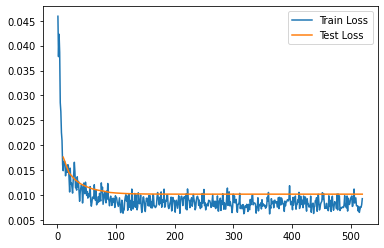

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 521 	Loss: 0.006410
Train Epoch: 521 	Loss: 0.008440
Train Epoch: 521 	Loss: 0.009570


Train Epoch: 522 	Loss: 0.007174
Train Epoch: 522 	Loss: 0.007056
Train Epoch: 522 	Loss: 0.007370


Train Epoch: 523 	Loss: 0.009585
Train Epoch: 523 	Loss: 0.009693
Train Epoch: 523 	Loss: 0.009737


Train Epoch: 524 	Loss: 0.010099
Train Epoch: 524 	Loss: 0.008817
Train Epoch: 524 	Loss: 0.008579


Train Epoch: 525 	Loss: 0.009266
Train Epoch: 525 	Loss: 0.007740
Train Epoch: 525 	Loss: 0.007487


Train Epoch: 526 	Loss: 0.007826
Train Epoch: 526 	Loss: 0.007498
Train Epoch: 526 	Loss: 0.009182


Train Epoch: 527 	Loss: 0.009020
Train Epoch: 527 	Loss: 0.008203
Train Epoch: 527 	Loss: 0.007914


Train Epoch: 528 	Loss: 0.007923
Train Epoch: 528 	Loss: 0.006694
Train Epoch: 528 	Loss: 0.007735


Train Epoch: 529 	Loss: 0.009853
Train Epoch: 529 	Loss: 0.009544
Train Epoch: 529 	Loss: 0.008842


Train Epoch: 530 	Loss: 0.008895
Train Epoch: 530 	Loss: 0.007385
Train Epoch: 530 	Loss: 0

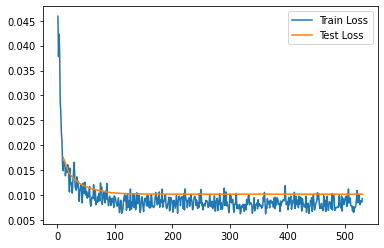

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 531 	Loss: 0.009951
Train Epoch: 531 	Loss: 0.008345
Train Epoch: 531 	Loss: 0.009051


Train Epoch: 532 	Loss: 0.009219
Train Epoch: 532 	Loss: 0.008901
Train Epoch: 532 	Loss: 0.010826


Train Epoch: 533 	Loss: 0.007820
Train Epoch: 533 	Loss: 0.008848
Train Epoch: 533 	Loss: 0.009981


Train Epoch: 534 	Loss: 0.006906
Train Epoch: 534 	Loss: 0.008848
Train Epoch: 534 	Loss: 0.009041


Train Epoch: 535 	Loss: 0.007643
Train Epoch: 535 	Loss: 0.008597
Train Epoch: 535 	Loss: 0.009412


Train Epoch: 536 	Loss: 0.008356
Train Epoch: 536 	Loss: 0.009197
Train Epoch: 536 	Loss: 0.008749


Train Epoch: 537 	Loss: 0.009050
Train Epoch: 537 	Loss: 0.007416
Train Epoch: 537 	Loss: 0.009422


Train Epoch: 538 	Loss: 0.009350
Train Epoch: 538 	Loss: 0.007139
Train Epoch: 538 	Loss: 0.009924


Train Epoch: 539 	Loss: 0.005814
Train Epoch: 539 	Loss: 0.007169
Train Epoch: 539 	Loss: 0.009008


Train Epoch: 540 	Loss: 0.009215
Train Epoch: 540 	Loss: 0.008320
Train Epoch: 540 	Loss: 0

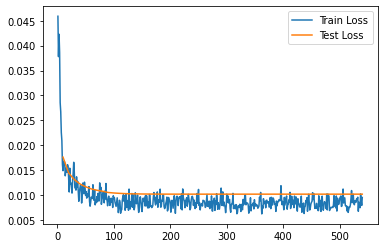

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 541 	Loss: 0.008612
Train Epoch: 541 	Loss: 0.007614
Train Epoch: 541 	Loss: 0.007100


Train Epoch: 542 	Loss: 0.009470
Train Epoch: 542 	Loss: 0.009364
Train Epoch: 542 	Loss: 0.009134


Train Epoch: 543 	Loss: 0.010240
Train Epoch: 543 	Loss: 0.011106
Train Epoch: 543 	Loss: 0.007778


Train Epoch: 544 	Loss: 0.007949
Train Epoch: 544 	Loss: 0.008296
Train Epoch: 544 	Loss: 0.008078


Train Epoch: 545 	Loss: 0.007930
Train Epoch: 545 	Loss: 0.008873
Train Epoch: 545 	Loss: 0.008111


Train Epoch: 546 	Loss: 0.008868
Train Epoch: 546 	Loss: 0.008514
Train Epoch: 546 	Loss: 0.008861


Train Epoch: 547 	Loss: 0.010238
Train Epoch: 547 	Loss: 0.007515
Train Epoch: 547 	Loss: 0.010002


Train Epoch: 548 	Loss: 0.007795
Train Epoch: 548 	Loss: 0.007759
Train Epoch: 548 	Loss: 0.009703


Train Epoch: 549 	Loss: 0.006523
Train Epoch: 549 	Loss: 0.008083
Train Epoch: 549 	Loss: 0.006610


Train Epoch: 550 	Loss: 0.007349
Train Epoch: 550 	Loss: 0.008973
Train Epoch: 550 	Loss: 0

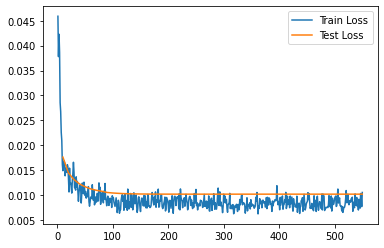

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 551 	Loss: 0.006425
Train Epoch: 551 	Loss: 0.007834
Train Epoch: 551 	Loss: 0.009316


Train Epoch: 552 	Loss: 0.008224
Train Epoch: 552 	Loss: 0.008715
Train Epoch: 552 	Loss: 0.009029


Train Epoch: 553 	Loss: 0.009179
Train Epoch: 553 	Loss: 0.007782
Train Epoch: 553 	Loss: 0.009329


Train Epoch: 554 	Loss: 0.009138
Train Epoch: 554 	Loss: 0.006921
Train Epoch: 554 	Loss: 0.009531


Train Epoch: 555 	Loss: 0.009323
Train Epoch: 555 	Loss: 0.010363
Train Epoch: 555 	Loss: 0.009536


Train Epoch: 556 	Loss: 0.009269
Train Epoch: 556 	Loss: 0.007813
Train Epoch: 556 	Loss: 0.008108


Train Epoch: 557 	Loss: 0.008429
Train Epoch: 557 	Loss: 0.009770
Train Epoch: 557 	Loss: 0.008861


Train Epoch: 558 	Loss: 0.006191
Train Epoch: 558 	Loss: 0.007760
Train Epoch: 558 	Loss: 0.008659


Train Epoch: 559 	Loss: 0.006511
Train Epoch: 559 	Loss: 0.009227
Train Epoch: 559 	Loss: 0.008762


Train Epoch: 560 	Loss: 0.009565
Train Epoch: 560 	Loss: 0.008694
Train Epoch: 560 	Loss: 0

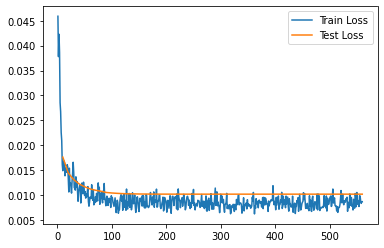

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 561 	Loss: 0.009514
Train Epoch: 561 	Loss: 0.006748
Train Epoch: 561 	Loss: 0.009696


Train Epoch: 562 	Loss: 0.008929
Train Epoch: 562 	Loss: 0.007945
Train Epoch: 562 	Loss: 0.009107


Train Epoch: 563 	Loss: 0.010480
Train Epoch: 563 	Loss: 0.008275
Train Epoch: 563 	Loss: 0.008925


Train Epoch: 564 	Loss: 0.009497
Train Epoch: 564 	Loss: 0.008372
Train Epoch: 564 	Loss: 0.009410


Train Epoch: 565 	Loss: 0.007947
Train Epoch: 565 	Loss: 0.008264
Train Epoch: 565 	Loss: 0.006303


Train Epoch: 566 	Loss: 0.007894
Train Epoch: 566 	Loss: 0.007992
Train Epoch: 566 	Loss: 0.006991


Train Epoch: 567 	Loss: 0.008270
Train Epoch: 567 	Loss: 0.008185
Train Epoch: 567 	Loss: 0.006885


Train Epoch: 568 	Loss: 0.010320
Train Epoch: 568 	Loss: 0.006428
Train Epoch: 568 	Loss: 0.009848


Train Epoch: 569 	Loss: 0.009155
Train Epoch: 569 	Loss: 0.008129
Train Epoch: 569 	Loss: 0.007395


Train Epoch: 570 	Loss: 0.008661
Train Epoch: 570 	Loss: 0.010201
Train Epoch: 570 	Loss: 0

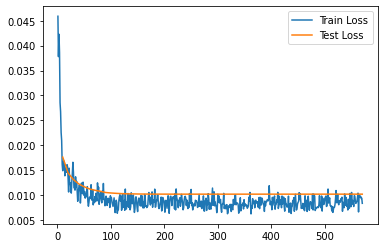

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 571 	Loss: 0.008151
Train Epoch: 571 	Loss: 0.006753
Train Epoch: 571 	Loss: 0.008483


Train Epoch: 572 	Loss: 0.007173
Train Epoch: 572 	Loss: 0.009595
Train Epoch: 572 	Loss: 0.008367


Train Epoch: 573 	Loss: 0.009070
Train Epoch: 573 	Loss: 0.006545
Train Epoch: 573 	Loss: 0.007311


Train Epoch: 574 	Loss: 0.006924
Train Epoch: 574 	Loss: 0.008121
Train Epoch: 574 	Loss: 0.008389


Train Epoch: 575 	Loss: 0.008882
Train Epoch: 575 	Loss: 0.010196
Train Epoch: 575 	Loss: 0.008521


Train Epoch: 576 	Loss: 0.007384
Train Epoch: 576 	Loss: 0.009197
Train Epoch: 576 	Loss: 0.008791


Train Epoch: 577 	Loss: 0.009589
Train Epoch: 577 	Loss: 0.007230
Train Epoch: 577 	Loss: 0.008099


Train Epoch: 578 	Loss: 0.008251
Train Epoch: 578 	Loss: 0.008434
Train Epoch: 578 	Loss: 0.008051


Train Epoch: 579 	Loss: 0.006307
Train Epoch: 579 	Loss: 0.007935
Train Epoch: 579 	Loss: 0.008221


Train Epoch: 580 	Loss: 0.009251
Train Epoch: 580 	Loss: 0.008956
Train Epoch: 580 	Loss: 0

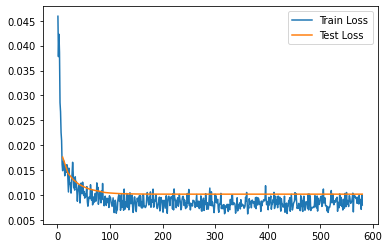

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 581 	Loss: 0.006581
Train Epoch: 581 	Loss: 0.008669
Train Epoch: 581 	Loss: 0.007577


Train Epoch: 582 	Loss: 0.008905
Train Epoch: 582 	Loss: 0.010039
Train Epoch: 582 	Loss: 0.007255


Train Epoch: 583 	Loss: 0.011210
Train Epoch: 583 	Loss: 0.007627
Train Epoch: 583 	Loss: 0.008222


Train Epoch: 584 	Loss: 0.006635
Train Epoch: 584 	Loss: 0.006801
Train Epoch: 584 	Loss: 0.008539


Train Epoch: 585 	Loss: 0.007971
Train Epoch: 585 	Loss: 0.006875
Train Epoch: 585 	Loss: 0.008693


Train Epoch: 586 	Loss: 0.007373
Train Epoch: 586 	Loss: 0.007138
Train Epoch: 586 	Loss: 0.009987


Train Epoch: 587 	Loss: 0.008822
Train Epoch: 587 	Loss: 0.007844
Train Epoch: 587 	Loss: 0.008405


Train Epoch: 588 	Loss: 0.008012
Train Epoch: 588 	Loss: 0.008618
Train Epoch: 588 	Loss: 0.008617


Train Epoch: 589 	Loss: 0.008181
Train Epoch: 589 	Loss: 0.007671
Train Epoch: 589 	Loss: 0.006759


Train Epoch: 590 	Loss: 0.007538
Train Epoch: 590 	Loss: 0.007104
Train Epoch: 590 	Loss: 0

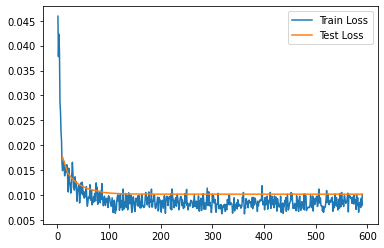

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 591 	Loss: 0.007364
Train Epoch: 591 	Loss: 0.009047
Train Epoch: 591 	Loss: 0.008430


Train Epoch: 592 	Loss: 0.009799
Train Epoch: 592 	Loss: 0.007350
Train Epoch: 592 	Loss: 0.007437


Train Epoch: 593 	Loss: 0.006395
Train Epoch: 593 	Loss: 0.008146
Train Epoch: 593 	Loss: 0.007880


Train Epoch: 594 	Loss: 0.007330
Train Epoch: 594 	Loss: 0.007503
Train Epoch: 594 	Loss: 0.008482


Train Epoch: 595 	Loss: 0.008349
Train Epoch: 595 	Loss: 0.008149
Train Epoch: 595 	Loss: 0.007963


Train Epoch: 596 	Loss: 0.007487
Train Epoch: 596 	Loss: 0.009790
Train Epoch: 596 	Loss: 0.007944


Train Epoch: 597 	Loss: 0.007472
Train Epoch: 597 	Loss: 0.007592
Train Epoch: 597 	Loss: 0.008771


Train Epoch: 598 	Loss: 0.008170
Train Epoch: 598 	Loss: 0.009703
Train Epoch: 598 	Loss: 0.007364


Train Epoch: 599 	Loss: 0.007486
Train Epoch: 599 	Loss: 0.007874
Train Epoch: 599 	Loss: 0.009288


Train Epoch: 600 	Loss: 0.007784
Train Epoch: 600 	Loss: 0.010646
Train Epoch: 600 	Loss: 0

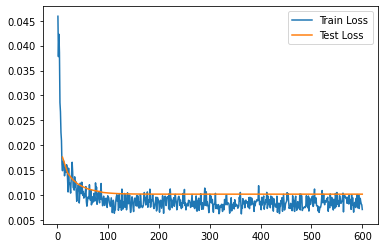

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 601 	Loss: 0.008541
Train Epoch: 601 	Loss: 0.009991
Train Epoch: 601 	Loss: 0.010833


Train Epoch: 602 	Loss: 0.008089
Train Epoch: 602 	Loss: 0.009750
Train Epoch: 602 	Loss: 0.011577


Train Epoch: 603 	Loss: 0.007420
Train Epoch: 603 	Loss: 0.007936
Train Epoch: 603 	Loss: 0.008131


Train Epoch: 604 	Loss: 0.010353
Train Epoch: 604 	Loss: 0.007360
Train Epoch: 604 	Loss: 0.008752


Train Epoch: 605 	Loss: 0.008981
Train Epoch: 605 	Loss: 0.009694
Train Epoch: 605 	Loss: 0.007919


Train Epoch: 606 	Loss: 0.007824
Train Epoch: 606 	Loss: 0.009487
Train Epoch: 606 	Loss: 0.008522


Train Epoch: 607 	Loss: 0.009045
Train Epoch: 607 	Loss: 0.009311
Train Epoch: 607 	Loss: 0.007703


Train Epoch: 608 	Loss: 0.006536
Train Epoch: 608 	Loss: 0.006890
Train Epoch: 608 	Loss: 0.006559


Train Epoch: 609 	Loss: 0.007954
Train Epoch: 609 	Loss: 0.007462
Train Epoch: 609 	Loss: 0.009280


Train Epoch: 610 	Loss: 0.007130
Train Epoch: 610 	Loss: 0.008666
Train Epoch: 610 	Loss: 0

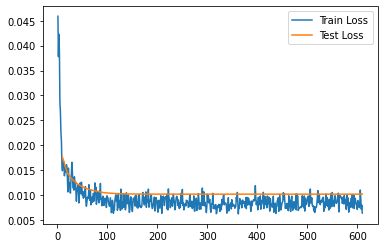

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 611 	Loss: 0.009040
Train Epoch: 611 	Loss: 0.009952
Train Epoch: 611 	Loss: 0.010025


Train Epoch: 612 	Loss: 0.008680
Train Epoch: 612 	Loss: 0.008343
Train Epoch: 612 	Loss: 0.008406


Train Epoch: 613 	Loss: 0.008717
Train Epoch: 613 	Loss: 0.007528
Train Epoch: 613 	Loss: 0.007571


Train Epoch: 614 	Loss: 0.008182
Train Epoch: 614 	Loss: 0.008657
Train Epoch: 614 	Loss: 0.007545


Train Epoch: 615 	Loss: 0.007427
Train Epoch: 615 	Loss: 0.007697
Train Epoch: 615 	Loss: 0.007526


Train Epoch: 616 	Loss: 0.008053
Train Epoch: 616 	Loss: 0.006781
Train Epoch: 616 	Loss: 0.008357


Train Epoch: 617 	Loss: 0.007160
Train Epoch: 617 	Loss: 0.007987
Train Epoch: 617 	Loss: 0.009545


Train Epoch: 618 	Loss: 0.008074
Train Epoch: 618 	Loss: 0.008681
Train Epoch: 618 	Loss: 0.009525


Train Epoch: 619 	Loss: 0.007194
Train Epoch: 619 	Loss: 0.009155
Train Epoch: 619 	Loss: 0.008773


Train Epoch: 620 	Loss: 0.008103
Train Epoch: 620 	Loss: 0.008084
Train Epoch: 620 	Loss: 0

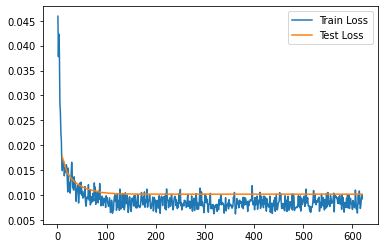

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 621 	Loss: 0.009188
Train Epoch: 621 	Loss: 0.007106
Train Epoch: 621 	Loss: 0.007975


Train Epoch: 622 	Loss: 0.010278
Train Epoch: 622 	Loss: 0.008987
Train Epoch: 622 	Loss: 0.008347


Train Epoch: 623 	Loss: 0.008484
Train Epoch: 623 	Loss: 0.007892
Train Epoch: 623 	Loss: 0.009284


Train Epoch: 624 	Loss: 0.008156
Train Epoch: 624 	Loss: 0.008766
Train Epoch: 624 	Loss: 0.009188


Train Epoch: 625 	Loss: 0.008685
Train Epoch: 625 	Loss: 0.008557
Train Epoch: 625 	Loss: 0.008399


Train Epoch: 626 	Loss: 0.009337
Train Epoch: 626 	Loss: 0.009284
Train Epoch: 626 	Loss: 0.007252


Train Epoch: 627 	Loss: 0.008501
Train Epoch: 627 	Loss: 0.007282
Train Epoch: 627 	Loss: 0.006897


Train Epoch: 628 	Loss: 0.008076
Train Epoch: 628 	Loss: 0.008721
Train Epoch: 628 	Loss: 0.006134


Train Epoch: 629 	Loss: 0.008089
Train Epoch: 629 	Loss: 0.007343
Train Epoch: 629 	Loss: 0.007466


Train Epoch: 630 	Loss: 0.007932
Train Epoch: 630 	Loss: 0.008654
Train Epoch: 630 	Loss: 0

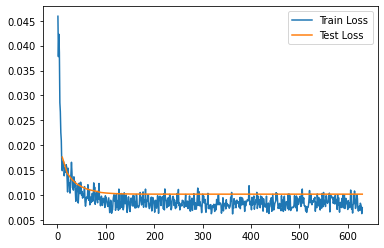

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 631 	Loss: 0.010538
Train Epoch: 631 	Loss: 0.007328
Train Epoch: 631 	Loss: 0.008375


Train Epoch: 632 	Loss: 0.006526
Train Epoch: 632 	Loss: 0.009227
Train Epoch: 632 	Loss: 0.011318


Train Epoch: 633 	Loss: 0.008250
Train Epoch: 633 	Loss: 0.009440
Train Epoch: 633 	Loss: 0.008975


Train Epoch: 634 	Loss: 0.009512
Train Epoch: 634 	Loss: 0.008539
Train Epoch: 634 	Loss: 0.008226


Train Epoch: 635 	Loss: 0.006519
Train Epoch: 635 	Loss: 0.009182
Train Epoch: 635 	Loss: 0.009697


Train Epoch: 636 	Loss: 0.007023
Train Epoch: 636 	Loss: 0.007776
Train Epoch: 636 	Loss: 0.010184


Train Epoch: 637 	Loss: 0.009264
Train Epoch: 637 	Loss: 0.009227
Train Epoch: 637 	Loss: 0.009661


Train Epoch: 638 	Loss: 0.007663
Train Epoch: 638 	Loss: 0.008743
Train Epoch: 638 	Loss: 0.009126


Train Epoch: 639 	Loss: 0.007882
Train Epoch: 639 	Loss: 0.008730
Train Epoch: 639 	Loss: 0.009486


Train Epoch: 640 	Loss: 0.007445
Train Epoch: 640 	Loss: 0.007532
Train Epoch: 640 	Loss: 0

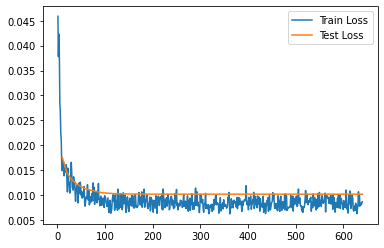

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 641 	Loss: 0.006978
Train Epoch: 641 	Loss: 0.009510
Train Epoch: 641 	Loss: 0.008542


Train Epoch: 642 	Loss: 0.007469
Train Epoch: 642 	Loss: 0.007633
Train Epoch: 642 	Loss: 0.007581


Train Epoch: 643 	Loss: 0.008853
Train Epoch: 643 	Loss: 0.009088
Train Epoch: 643 	Loss: 0.009688


Train Epoch: 644 	Loss: 0.007948
Train Epoch: 644 	Loss: 0.007579
Train Epoch: 644 	Loss: 0.007213


Train Epoch: 645 	Loss: 0.009539
Train Epoch: 645 	Loss: 0.010443
Train Epoch: 645 	Loss: 0.010418


Train Epoch: 646 	Loss: 0.008465
Train Epoch: 646 	Loss: 0.007430
Train Epoch: 646 	Loss: 0.008902


Train Epoch: 647 	Loss: 0.009188
Train Epoch: 647 	Loss: 0.008943
Train Epoch: 647 	Loss: 0.009457


Train Epoch: 648 	Loss: 0.009485
Train Epoch: 648 	Loss: 0.008924
Train Epoch: 648 	Loss: 0.008938


Train Epoch: 649 	Loss: 0.008455
Train Epoch: 649 	Loss: 0.008254
Train Epoch: 649 	Loss: 0.009857


Train Epoch: 650 	Loss: 0.008903
Train Epoch: 650 	Loss: 0.008306
Train Epoch: 650 	Loss: 0

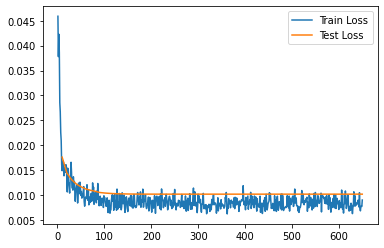

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 651 	Loss: 0.008867
Train Epoch: 651 	Loss: 0.009947
Train Epoch: 651 	Loss: 0.008914


Train Epoch: 652 	Loss: 0.009819
Train Epoch: 652 	Loss: 0.010568
Train Epoch: 652 	Loss: 0.008291


Train Epoch: 653 	Loss: 0.010952
Train Epoch: 653 	Loss: 0.008046
Train Epoch: 653 	Loss: 0.009614


Train Epoch: 654 	Loss: 0.007382
Train Epoch: 654 	Loss: 0.008307
Train Epoch: 654 	Loss: 0.009069


Train Epoch: 655 	Loss: 0.007321
Train Epoch: 655 	Loss: 0.009887
Train Epoch: 655 	Loss: 0.007317


Train Epoch: 656 	Loss: 0.010883
Train Epoch: 656 	Loss: 0.009041
Train Epoch: 656 	Loss: 0.008748


Train Epoch: 657 	Loss: 0.007817
Train Epoch: 657 	Loss: 0.007576
Train Epoch: 657 	Loss: 0.008748


Train Epoch: 658 	Loss: 0.008959
Train Epoch: 658 	Loss: 0.008504
Train Epoch: 658 	Loss: 0.010952


Train Epoch: 659 	Loss: 0.009888
Train Epoch: 659 	Loss: 0.007993
Train Epoch: 659 	Loss: 0.009440


Train Epoch: 660 	Loss: 0.011425
Train Epoch: 660 	Loss: 0.010123
Train Epoch: 660 	Loss: 0

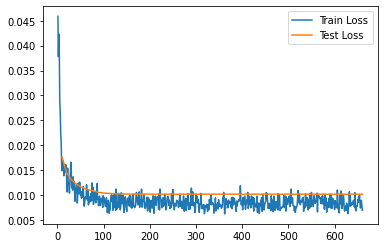

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 661 	Loss: 0.009180
Train Epoch: 661 	Loss: 0.008064
Train Epoch: 661 	Loss: 0.007937


Train Epoch: 662 	Loss: 0.008253
Train Epoch: 662 	Loss: 0.008312
Train Epoch: 662 	Loss: 0.008521


Train Epoch: 663 	Loss: 0.006130
Train Epoch: 663 	Loss: 0.008180
Train Epoch: 663 	Loss: 0.007833


Train Epoch: 664 	Loss: 0.010527
Train Epoch: 664 	Loss: 0.008223
Train Epoch: 664 	Loss: 0.008574


Train Epoch: 665 	Loss: 0.007947
Train Epoch: 665 	Loss: 0.008749
Train Epoch: 665 	Loss: 0.008783


Train Epoch: 666 	Loss: 0.008994
Train Epoch: 666 	Loss: 0.007317
Train Epoch: 666 	Loss: 0.007604


Train Epoch: 667 	Loss: 0.009759
Train Epoch: 667 	Loss: 0.006327
Train Epoch: 667 	Loss: 0.009186


Train Epoch: 668 	Loss: 0.010206
Train Epoch: 668 	Loss: 0.009047
Train Epoch: 668 	Loss: 0.009321


Train Epoch: 669 	Loss: 0.009221
Train Epoch: 669 	Loss: 0.007805
Train Epoch: 669 	Loss: 0.009034


Train Epoch: 670 	Loss: 0.009237
Train Epoch: 670 	Loss: 0.009568
Train Epoch: 670 	Loss: 0

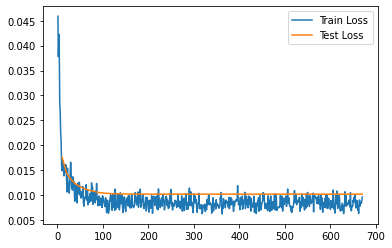

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 671 	Loss: 0.007721
Train Epoch: 671 	Loss: 0.008633
Train Epoch: 671 	Loss: 0.010653


Train Epoch: 672 	Loss: 0.008632
Train Epoch: 672 	Loss: 0.008984
Train Epoch: 672 	Loss: 0.008854


Train Epoch: 673 	Loss: 0.007640
Train Epoch: 673 	Loss: 0.008169
Train Epoch: 673 	Loss: 0.008366


Train Epoch: 674 	Loss: 0.008632
Train Epoch: 674 	Loss: 0.006723
Train Epoch: 674 	Loss: 0.009329


Train Epoch: 675 	Loss: 0.008271
Train Epoch: 675 	Loss: 0.008100
Train Epoch: 675 	Loss: 0.007899


Train Epoch: 676 	Loss: 0.007725
Train Epoch: 676 	Loss: 0.008992
Train Epoch: 676 	Loss: 0.009526


Train Epoch: 677 	Loss: 0.008234
Train Epoch: 677 	Loss: 0.009506
Train Epoch: 677 	Loss: 0.010398


Train Epoch: 678 	Loss: 0.008290
Train Epoch: 678 	Loss: 0.007678
Train Epoch: 678 	Loss: 0.009569


Train Epoch: 679 	Loss: 0.007580
Train Epoch: 679 	Loss: 0.006859
Train Epoch: 679 	Loss: 0.009520


Train Epoch: 680 	Loss: 0.007605
Train Epoch: 680 	Loss: 0.008755
Train Epoch: 680 	Loss: 0

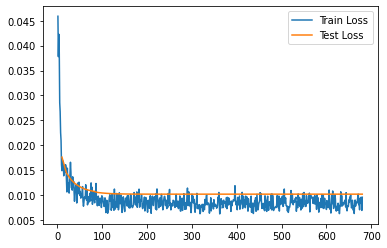

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 681 	Loss: 0.008938
Train Epoch: 681 	Loss: 0.007661
Train Epoch: 681 	Loss: 0.008294


Train Epoch: 682 	Loss: 0.007771
Train Epoch: 682 	Loss: 0.007453
Train Epoch: 682 	Loss: 0.007085


Train Epoch: 683 	Loss: 0.006917
Train Epoch: 683 	Loss: 0.010281
Train Epoch: 683 	Loss: 0.007670


Train Epoch: 684 	Loss: 0.007729
Train Epoch: 684 	Loss: 0.008146
Train Epoch: 684 	Loss: 0.007677


Train Epoch: 685 	Loss: 0.010942
Train Epoch: 685 	Loss: 0.007609
Train Epoch: 685 	Loss: 0.007601


Train Epoch: 686 	Loss: 0.008084
Train Epoch: 686 	Loss: 0.009900
Train Epoch: 686 	Loss: 0.008630


Train Epoch: 687 	Loss: 0.007466
Train Epoch: 687 	Loss: 0.006549
Train Epoch: 687 	Loss: 0.008977


Train Epoch: 688 	Loss: 0.008338
Train Epoch: 688 	Loss: 0.008690
Train Epoch: 688 	Loss: 0.009734


Train Epoch: 689 	Loss: 0.010120
Train Epoch: 689 	Loss: 0.008234
Train Epoch: 689 	Loss: 0.009389


Train Epoch: 690 	Loss: 0.009019
Train Epoch: 690 	Loss: 0.007933
Train Epoch: 690 	Loss: 0

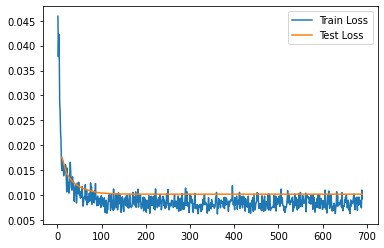

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 691 	Loss: 0.008547
Train Epoch: 691 	Loss: 0.007799
Train Epoch: 691 	Loss: 0.007550


Train Epoch: 692 	Loss: 0.010914
Train Epoch: 692 	Loss: 0.007815
Train Epoch: 692 	Loss: 0.009255


Train Epoch: 693 	Loss: 0.009441
Train Epoch: 693 	Loss: 0.009436
Train Epoch: 693 	Loss: 0.009078


Train Epoch: 694 	Loss: 0.007629
Train Epoch: 694 	Loss: 0.009451
Train Epoch: 694 	Loss: 0.008418


Train Epoch: 695 	Loss: 0.007260
Train Epoch: 695 	Loss: 0.007872
Train Epoch: 695 	Loss: 0.009041


Train Epoch: 696 	Loss: 0.007457
Train Epoch: 696 	Loss: 0.009897
Train Epoch: 696 	Loss: 0.006790


Train Epoch: 697 	Loss: 0.008633
Train Epoch: 697 	Loss: 0.008518
Train Epoch: 697 	Loss: 0.010797


Train Epoch: 698 	Loss: 0.010350
Train Epoch: 698 	Loss: 0.009411
Train Epoch: 698 	Loss: 0.008188


Train Epoch: 699 	Loss: 0.009438
Train Epoch: 699 	Loss: 0.009035
Train Epoch: 699 	Loss: 0.008188


Train Epoch: 700 	Loss: 0.009644
Train Epoch: 700 	Loss: 0.006248
Train Epoch: 700 	Loss: 0

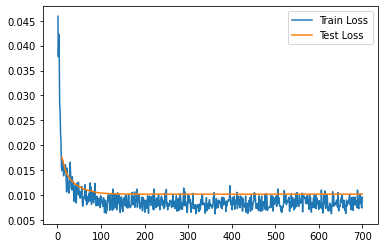

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 701 	Loss: 0.007510
Train Epoch: 701 	Loss: 0.008364
Train Epoch: 701 	Loss: 0.008944


Train Epoch: 702 	Loss: 0.008626
Train Epoch: 702 	Loss: 0.010265
Train Epoch: 702 	Loss: 0.009391


Train Epoch: 703 	Loss: 0.008362
Train Epoch: 703 	Loss: 0.009863
Train Epoch: 703 	Loss: 0.010663


Train Epoch: 704 	Loss: 0.008025
Train Epoch: 704 	Loss: 0.009265
Train Epoch: 704 	Loss: 0.008417


Train Epoch: 705 	Loss: 0.008065
Train Epoch: 705 	Loss: 0.009028
Train Epoch: 705 	Loss: 0.008032


Train Epoch: 706 	Loss: 0.008836
Train Epoch: 706 	Loss: 0.008231
Train Epoch: 706 	Loss: 0.008211


Train Epoch: 707 	Loss: 0.008348
Train Epoch: 707 	Loss: 0.009203
Train Epoch: 707 	Loss: 0.008150


Train Epoch: 708 	Loss: 0.008882
Train Epoch: 708 	Loss: 0.010782
Train Epoch: 708 	Loss: 0.008319


Train Epoch: 709 	Loss: 0.008240
Train Epoch: 709 	Loss: 0.007717
Train Epoch: 709 	Loss: 0.008526


Train Epoch: 710 	Loss: 0.007381
Train Epoch: 710 	Loss: 0.008301
Train Epoch: 710 	Loss: 0

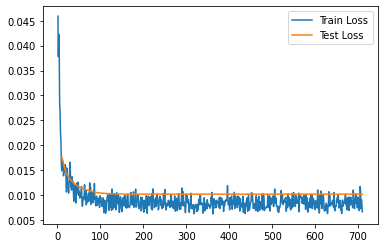

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 711 	Loss: 0.008929
Train Epoch: 711 	Loss: 0.008184
Train Epoch: 711 	Loss: 0.009437


Train Epoch: 712 	Loss: 0.008267
Train Epoch: 712 	Loss: 0.011498
Train Epoch: 712 	Loss: 0.008287


Train Epoch: 713 	Loss: 0.007822
Train Epoch: 713 	Loss: 0.008972
Train Epoch: 713 	Loss: 0.007380


Train Epoch: 714 	Loss: 0.008269
Train Epoch: 714 	Loss: 0.008373
Train Epoch: 714 	Loss: 0.007193


Train Epoch: 715 	Loss: 0.007657
Train Epoch: 715 	Loss: 0.010728
Train Epoch: 715 	Loss: 0.007582


Train Epoch: 716 	Loss: 0.006199
Train Epoch: 716 	Loss: 0.009716
Train Epoch: 716 	Loss: 0.009468


Train Epoch: 717 	Loss: 0.008182
Train Epoch: 717 	Loss: 0.008980
Train Epoch: 717 	Loss: 0.008363


Train Epoch: 718 	Loss: 0.006395
Train Epoch: 718 	Loss: 0.009467
Train Epoch: 718 	Loss: 0.009401


Train Epoch: 719 	Loss: 0.008699
Train Epoch: 719 	Loss: 0.010843
Train Epoch: 719 	Loss: 0.009978


Train Epoch: 720 	Loss: 0.007607
Train Epoch: 720 	Loss: 0.008519
Train Epoch: 720 	Loss: 0

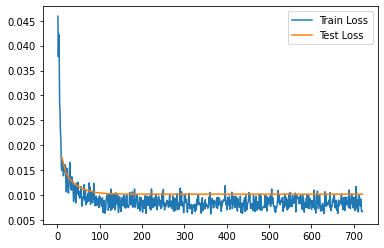

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 721 	Loss: 0.009326
Train Epoch: 721 	Loss: 0.009484
Train Epoch: 721 	Loss: 0.009585


Train Epoch: 722 	Loss: 0.009839
Train Epoch: 722 	Loss: 0.008301
Train Epoch: 722 	Loss: 0.005950


Train Epoch: 723 	Loss: 0.008243
Train Epoch: 723 	Loss: 0.006551
Train Epoch: 723 	Loss: 0.009572


Train Epoch: 724 	Loss: 0.009333
Train Epoch: 724 	Loss: 0.007587
Train Epoch: 724 	Loss: 0.008931


Train Epoch: 725 	Loss: 0.006923
Train Epoch: 725 	Loss: 0.008015
Train Epoch: 725 	Loss: 0.007154


Train Epoch: 726 	Loss: 0.009183
Train Epoch: 726 	Loss: 0.007454
Train Epoch: 726 	Loss: 0.008216


Train Epoch: 727 	Loss: 0.007803
Train Epoch: 727 	Loss: 0.011670
Train Epoch: 727 	Loss: 0.008698


Train Epoch: 728 	Loss: 0.008057
Train Epoch: 728 	Loss: 0.008838
Train Epoch: 728 	Loss: 0.007187


Train Epoch: 729 	Loss: 0.008001
Train Epoch: 729 	Loss: 0.008323
Train Epoch: 729 	Loss: 0.010332


Train Epoch: 730 	Loss: 0.009328
Train Epoch: 730 	Loss: 0.006832
Train Epoch: 730 	Loss: 0

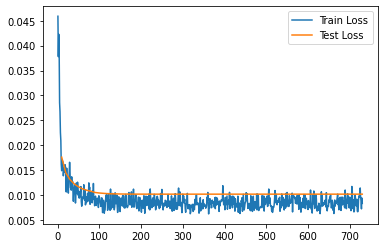

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 731 	Loss: 0.008839
Train Epoch: 731 	Loss: 0.008612
Train Epoch: 731 	Loss: 0.007659


Train Epoch: 732 	Loss: 0.009158
Train Epoch: 732 	Loss: 0.007723
Train Epoch: 732 	Loss: 0.006953


Train Epoch: 733 	Loss: 0.009736
Train Epoch: 733 	Loss: 0.007671
Train Epoch: 733 	Loss: 0.006894


Train Epoch: 734 	Loss: 0.006921
Train Epoch: 734 	Loss: 0.008797
Train Epoch: 734 	Loss: 0.008522


Train Epoch: 735 	Loss: 0.008026
Train Epoch: 735 	Loss: 0.008451
Train Epoch: 735 	Loss: 0.007610


Train Epoch: 736 	Loss: 0.009638
Train Epoch: 736 	Loss: 0.010104
Train Epoch: 736 	Loss: 0.008943


Train Epoch: 737 	Loss: 0.008905
Train Epoch: 737 	Loss: 0.008693
Train Epoch: 737 	Loss: 0.007727


Train Epoch: 738 	Loss: 0.006764
Train Epoch: 738 	Loss: 0.009892
Train Epoch: 738 	Loss: 0.007832


Train Epoch: 739 	Loss: 0.009434
Train Epoch: 739 	Loss: 0.007903
Train Epoch: 739 	Loss: 0.008970


Train Epoch: 740 	Loss: 0.007954
Train Epoch: 740 	Loss: 0.007774
Train Epoch: 740 	Loss: 0

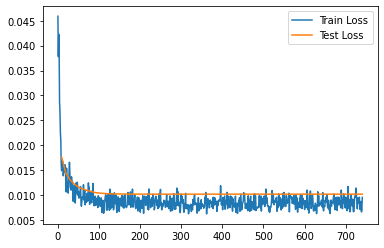

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 741 	Loss: 0.008284
Train Epoch: 741 	Loss: 0.008038
Train Epoch: 741 	Loss: 0.007458


Train Epoch: 742 	Loss: 0.009174
Train Epoch: 742 	Loss: 0.008765
Train Epoch: 742 	Loss: 0.007727


Train Epoch: 743 	Loss: 0.008094
Train Epoch: 743 	Loss: 0.008551
Train Epoch: 743 	Loss: 0.007864


Train Epoch: 744 	Loss: 0.009097
Train Epoch: 744 	Loss: 0.008500
Train Epoch: 744 	Loss: 0.009200


Train Epoch: 745 	Loss: 0.007381
Train Epoch: 745 	Loss: 0.008456
Train Epoch: 745 	Loss: 0.009011


Train Epoch: 746 	Loss: 0.008475
Train Epoch: 746 	Loss: 0.008090
Train Epoch: 746 	Loss: 0.008178


Train Epoch: 747 	Loss: 0.009953
Train Epoch: 747 	Loss: 0.008050
Train Epoch: 747 	Loss: 0.008150


Train Epoch: 748 	Loss: 0.007306
Train Epoch: 748 	Loss: 0.010304
Train Epoch: 748 	Loss: 0.010793


Train Epoch: 749 	Loss: 0.008311
Train Epoch: 749 	Loss: 0.008281
Train Epoch: 749 	Loss: 0.007575


Train Epoch: 750 	Loss: 0.007080
Train Epoch: 750 	Loss: 0.008743
Train Epoch: 750 	Loss: 0

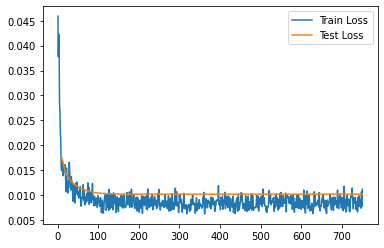

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 751 	Loss: 0.010703
Train Epoch: 751 	Loss: 0.007461
Train Epoch: 751 	Loss: 0.009957


Train Epoch: 752 	Loss: 0.007955
Train Epoch: 752 	Loss: 0.007560
Train Epoch: 752 	Loss: 0.009845


Train Epoch: 753 	Loss: 0.007897
Train Epoch: 753 	Loss: 0.008720
Train Epoch: 753 	Loss: 0.007281


Train Epoch: 754 	Loss: 0.009194
Train Epoch: 754 	Loss: 0.008331
Train Epoch: 754 	Loss: 0.009832


Train Epoch: 755 	Loss: 0.008350
Train Epoch: 755 	Loss: 0.009346
Train Epoch: 755 	Loss: 0.008897


Train Epoch: 756 	Loss: 0.011288
Train Epoch: 756 	Loss: 0.007824
Train Epoch: 756 	Loss: 0.008646


Train Epoch: 757 	Loss: 0.007277
Train Epoch: 757 	Loss: 0.010255
Train Epoch: 757 	Loss: 0.009514


Train Epoch: 758 	Loss: 0.007636
Train Epoch: 758 	Loss: 0.008036
Train Epoch: 758 	Loss: 0.008241


Train Epoch: 759 	Loss: 0.010126
Train Epoch: 759 	Loss: 0.009335
Train Epoch: 759 	Loss: 0.008644


Train Epoch: 760 	Loss: 0.006687
Train Epoch: 760 	Loss: 0.007366
Train Epoch: 760 	Loss: 0

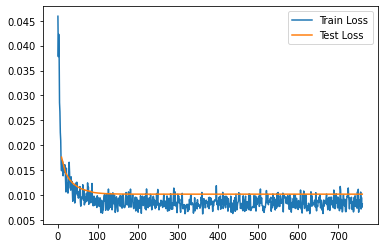

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 761 	Loss: 0.007206
Train Epoch: 761 	Loss: 0.010053
Train Epoch: 761 	Loss: 0.008578


Train Epoch: 762 	Loss: 0.006982
Train Epoch: 762 	Loss: 0.007644
Train Epoch: 762 	Loss: 0.008788


Train Epoch: 763 	Loss: 0.008604
Train Epoch: 763 	Loss: 0.007240
Train Epoch: 763 	Loss: 0.006822


Train Epoch: 764 	Loss: 0.007870
Train Epoch: 764 	Loss: 0.009361
Train Epoch: 764 	Loss: 0.008812


Train Epoch: 765 	Loss: 0.009534
Train Epoch: 765 	Loss: 0.008937
Train Epoch: 765 	Loss: 0.008695


Train Epoch: 766 	Loss: 0.008655
Train Epoch: 766 	Loss: 0.008432
Train Epoch: 766 	Loss: 0.007648


Train Epoch: 767 	Loss: 0.007887
Train Epoch: 767 	Loss: 0.007084
Train Epoch: 767 	Loss: 0.008905


Train Epoch: 768 	Loss: 0.008429
Train Epoch: 768 	Loss: 0.007951
Train Epoch: 768 	Loss: 0.009160


Train Epoch: 769 	Loss: 0.009020
Train Epoch: 769 	Loss: 0.009659
Train Epoch: 769 	Loss: 0.008266


Train Epoch: 770 	Loss: 0.008562
Train Epoch: 770 	Loss: 0.008465
Train Epoch: 770 	Loss: 0

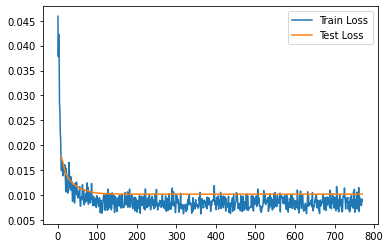

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 771 	Loss: 0.007766
Train Epoch: 771 	Loss: 0.008272
Train Epoch: 771 	Loss: 0.010274


Train Epoch: 772 	Loss: 0.007703
Train Epoch: 772 	Loss: 0.008775
Train Epoch: 772 	Loss: 0.008621


Train Epoch: 773 	Loss: 0.007281
Train Epoch: 773 	Loss: 0.007864
Train Epoch: 773 	Loss: 0.008722


Train Epoch: 774 	Loss: 0.006889
Train Epoch: 774 	Loss: 0.007708
Train Epoch: 774 	Loss: 0.008970


Train Epoch: 775 	Loss: 0.010355
Train Epoch: 775 	Loss: 0.008560
Train Epoch: 775 	Loss: 0.007229


Train Epoch: 776 	Loss: 0.008596
Train Epoch: 776 	Loss: 0.007505
Train Epoch: 776 	Loss: 0.008870


Train Epoch: 777 	Loss: 0.008329
Train Epoch: 777 	Loss: 0.009201
Train Epoch: 777 	Loss: 0.008920


Train Epoch: 778 	Loss: 0.008785
Train Epoch: 778 	Loss: 0.008913
Train Epoch: 778 	Loss: 0.007876


Train Epoch: 779 	Loss: 0.008679
Train Epoch: 779 	Loss: 0.008402
Train Epoch: 779 	Loss: 0.009070


Train Epoch: 780 	Loss: 0.006924
Train Epoch: 780 	Loss: 0.009115
Train Epoch: 780 	Loss: 0

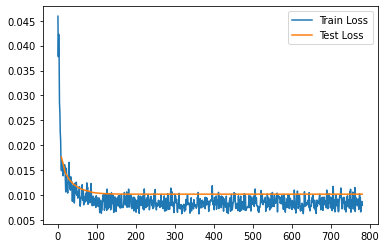

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 781 	Loss: 0.009556
Train Epoch: 781 	Loss: 0.007278
Train Epoch: 781 	Loss: 0.009145


Train Epoch: 782 	Loss: 0.010761
Train Epoch: 782 	Loss: 0.008857
Train Epoch: 782 	Loss: 0.009921


Train Epoch: 783 	Loss: 0.009439
Train Epoch: 783 	Loss: 0.007727
Train Epoch: 783 	Loss: 0.010251


Train Epoch: 784 	Loss: 0.010751
Train Epoch: 784 	Loss: 0.010074
Train Epoch: 784 	Loss: 0.008071


Train Epoch: 785 	Loss: 0.006951
Train Epoch: 785 	Loss: 0.007550
Train Epoch: 785 	Loss: 0.008673


Train Epoch: 786 	Loss: 0.009735
Train Epoch: 786 	Loss: 0.007394
Train Epoch: 786 	Loss: 0.009093


Train Epoch: 787 	Loss: 0.008357
Train Epoch: 787 	Loss: 0.008534
Train Epoch: 787 	Loss: 0.006748


Train Epoch: 788 	Loss: 0.008209
Train Epoch: 788 	Loss: 0.008114
Train Epoch: 788 	Loss: 0.009076


Train Epoch: 789 	Loss: 0.007554
Train Epoch: 789 	Loss: 0.008006
Train Epoch: 789 	Loss: 0.008282


Train Epoch: 790 	Loss: 0.008577
Train Epoch: 790 	Loss: 0.009132
Train Epoch: 790 	Loss: 0

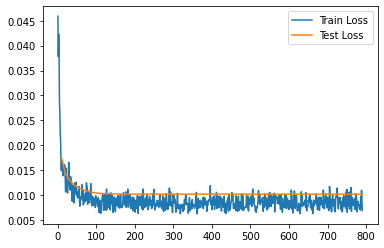

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 791 	Loss: 0.008552
Train Epoch: 791 	Loss: 0.009116
Train Epoch: 791 	Loss: 0.006952


Train Epoch: 792 	Loss: 0.008772
Train Epoch: 792 	Loss: 0.007096
Train Epoch: 792 	Loss: 0.009955


Train Epoch: 793 	Loss: 0.008406
Train Epoch: 793 	Loss: 0.007382
Train Epoch: 793 	Loss: 0.006276


Train Epoch: 794 	Loss: 0.008630
Train Epoch: 794 	Loss: 0.006738
Train Epoch: 794 	Loss: 0.009540


Train Epoch: 795 	Loss: 0.006125
Train Epoch: 795 	Loss: 0.007429
Train Epoch: 795 	Loss: 0.010856


Train Epoch: 796 	Loss: 0.009193
Train Epoch: 796 	Loss: 0.008968
Train Epoch: 796 	Loss: 0.010171


Train Epoch: 797 	Loss: 0.009674
Train Epoch: 797 	Loss: 0.007229
Train Epoch: 797 	Loss: 0.007468


Train Epoch: 798 	Loss: 0.007999
Train Epoch: 798 	Loss: 0.007021
Train Epoch: 798 	Loss: 0.008826


Train Epoch: 799 	Loss: 0.008101
Train Epoch: 799 	Loss: 0.007433
Train Epoch: 799 	Loss: 0.009176


Train Epoch: 800 	Loss: 0.010351
Train Epoch: 800 	Loss: 0.006733
Train Epoch: 800 	Loss: 0

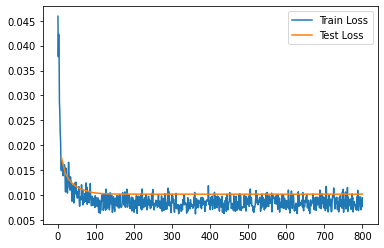

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 801 	Loss: 0.007733
Train Epoch: 801 	Loss: 0.008914
Train Epoch: 801 	Loss: 0.007526


Train Epoch: 802 	Loss: 0.007675
Train Epoch: 802 	Loss: 0.009267
Train Epoch: 802 	Loss: 0.008570


Train Epoch: 803 	Loss: 0.006252
Train Epoch: 803 	Loss: 0.008452
Train Epoch: 803 	Loss: 0.008876


Train Epoch: 804 	Loss: 0.007148
Train Epoch: 804 	Loss: 0.008850
Train Epoch: 804 	Loss: 0.008730


Train Epoch: 805 	Loss: 0.008728
Train Epoch: 805 	Loss: 0.007234
Train Epoch: 805 	Loss: 0.007445


Train Epoch: 806 	Loss: 0.007390
Train Epoch: 806 	Loss: 0.008508
Train Epoch: 806 	Loss: 0.006948


Train Epoch: 807 	Loss: 0.010481
Train Epoch: 807 	Loss: 0.007744
Train Epoch: 807 	Loss: 0.009207


Train Epoch: 808 	Loss: 0.009668
Train Epoch: 808 	Loss: 0.007258
Train Epoch: 808 	Loss: 0.006835


Train Epoch: 809 	Loss: 0.009992
Train Epoch: 809 	Loss: 0.007807
Train Epoch: 809 	Loss: 0.007680


Train Epoch: 810 	Loss: 0.008688
Train Epoch: 810 	Loss: 0.009214
Train Epoch: 810 	Loss: 0

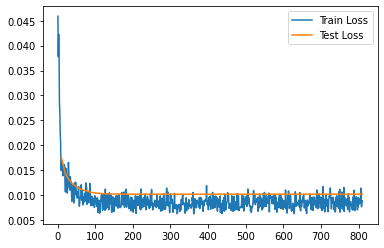

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 811 	Loss: 0.010032
Train Epoch: 811 	Loss: 0.010165
Train Epoch: 811 	Loss: 0.008863


Train Epoch: 812 	Loss: 0.008011
Train Epoch: 812 	Loss: 0.008833
Train Epoch: 812 	Loss: 0.007780


Train Epoch: 813 	Loss: 0.008368
Train Epoch: 813 	Loss: 0.008797
Train Epoch: 813 	Loss: 0.008502


Train Epoch: 814 	Loss: 0.007655
Train Epoch: 814 	Loss: 0.007156
Train Epoch: 814 	Loss: 0.009258


Train Epoch: 815 	Loss: 0.008811
Train Epoch: 815 	Loss: 0.007973
Train Epoch: 815 	Loss: 0.007160


Train Epoch: 816 	Loss: 0.007060
Train Epoch: 816 	Loss: 0.007520
Train Epoch: 816 	Loss: 0.008535


Train Epoch: 817 	Loss: 0.008250
Train Epoch: 817 	Loss: 0.008174
Train Epoch: 817 	Loss: 0.008200


Train Epoch: 818 	Loss: 0.008213
Train Epoch: 818 	Loss: 0.010604
Train Epoch: 818 	Loss: 0.008196


Train Epoch: 819 	Loss: 0.008766
Train Epoch: 819 	Loss: 0.006949
Train Epoch: 819 	Loss: 0.008510


Train Epoch: 820 	Loss: 0.007936
Train Epoch: 820 	Loss: 0.008585
Train Epoch: 820 	Loss: 0

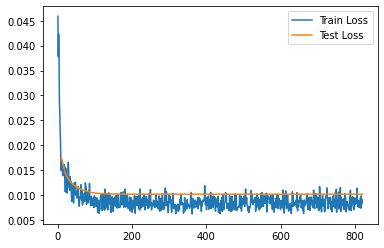

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 821 	Loss: 0.007510
Train Epoch: 821 	Loss: 0.009068
Train Epoch: 821 	Loss: 0.009267


Train Epoch: 822 	Loss: 0.008501
Train Epoch: 822 	Loss: 0.008212
Train Epoch: 822 	Loss: 0.008021


Train Epoch: 823 	Loss: 0.009395
Train Epoch: 823 	Loss: 0.009584
Train Epoch: 823 	Loss: 0.010152


Train Epoch: 824 	Loss: 0.006698
Train Epoch: 824 	Loss: 0.008337
Train Epoch: 824 	Loss: 0.009633


Train Epoch: 825 	Loss: 0.008354
Train Epoch: 825 	Loss: 0.008524
Train Epoch: 825 	Loss: 0.009224


Train Epoch: 826 	Loss: 0.007959
Train Epoch: 826 	Loss: 0.008100
Train Epoch: 826 	Loss: 0.009481


Train Epoch: 827 	Loss: 0.008328
Train Epoch: 827 	Loss: 0.007649
Train Epoch: 827 	Loss: 0.008582


Train Epoch: 828 	Loss: 0.008173
Train Epoch: 828 	Loss: 0.007831
Train Epoch: 828 	Loss: 0.007893


Train Epoch: 829 	Loss: 0.008820
Train Epoch: 829 	Loss: 0.008620
Train Epoch: 829 	Loss: 0.008039


Train Epoch: 830 	Loss: 0.009858
Train Epoch: 830 	Loss: 0.007830
Train Epoch: 830 	Loss: 0

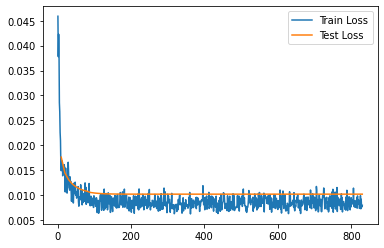

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 831 	Loss: 0.010677
Train Epoch: 831 	Loss: 0.009425
Train Epoch: 831 	Loss: 0.007510


Train Epoch: 832 	Loss: 0.007850
Train Epoch: 832 	Loss: 0.008758
Train Epoch: 832 	Loss: 0.008454


Train Epoch: 833 	Loss: 0.009527
Train Epoch: 833 	Loss: 0.009104
Train Epoch: 833 	Loss: 0.009119


Train Epoch: 834 	Loss: 0.006406
Train Epoch: 834 	Loss: 0.007987
Train Epoch: 834 	Loss: 0.008351


Train Epoch: 835 	Loss: 0.008629
Train Epoch: 835 	Loss: 0.008528
Train Epoch: 835 	Loss: 0.008386


Train Epoch: 836 	Loss: 0.010476
Train Epoch: 836 	Loss: 0.008286
Train Epoch: 836 	Loss: 0.009861


Train Epoch: 837 	Loss: 0.007932
Train Epoch: 837 	Loss: 0.008687
Train Epoch: 837 	Loss: 0.008055


Train Epoch: 838 	Loss: 0.009874
Train Epoch: 838 	Loss: 0.008208
Train Epoch: 838 	Loss: 0.008915


Train Epoch: 839 	Loss: 0.007576
Train Epoch: 839 	Loss: 0.006613
Train Epoch: 839 	Loss: 0.007736


Train Epoch: 840 	Loss: 0.008462
Train Epoch: 840 	Loss: 0.007643
Train Epoch: 840 	Loss: 0

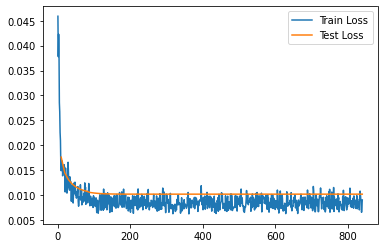

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 841 	Loss: 0.007456
Train Epoch: 841 	Loss: 0.009366
Train Epoch: 841 	Loss: 0.008153


Train Epoch: 842 	Loss: 0.008509
Train Epoch: 842 	Loss: 0.008987
Train Epoch: 842 	Loss: 0.008285


Train Epoch: 843 	Loss: 0.011287
Train Epoch: 843 	Loss: 0.008488
Train Epoch: 843 	Loss: 0.009506


Train Epoch: 844 	Loss: 0.010367
Train Epoch: 844 	Loss: 0.007527
Train Epoch: 844 	Loss: 0.008061


Train Epoch: 845 	Loss: 0.008816
Train Epoch: 845 	Loss: 0.009603
Train Epoch: 845 	Loss: 0.007006


Train Epoch: 846 	Loss: 0.007070
Train Epoch: 846 	Loss: 0.007720
Train Epoch: 846 	Loss: 0.009375


Train Epoch: 847 	Loss: 0.010027
Train Epoch: 847 	Loss: 0.007578
Train Epoch: 847 	Loss: 0.008716


Train Epoch: 848 	Loss: 0.008882
Train Epoch: 848 	Loss: 0.007405
Train Epoch: 848 	Loss: 0.008111


Train Epoch: 849 	Loss: 0.009053
Train Epoch: 849 	Loss: 0.008603
Train Epoch: 849 	Loss: 0.007880


Train Epoch: 850 	Loss: 0.010403
Train Epoch: 850 	Loss: 0.009653
Train Epoch: 850 	Loss: 0

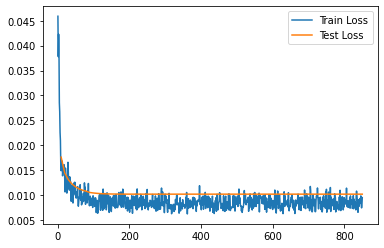

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 851 	Loss: 0.007028
Train Epoch: 851 	Loss: 0.007972
Train Epoch: 851 	Loss: 0.009485


Train Epoch: 852 	Loss: 0.007357
Train Epoch: 852 	Loss: 0.008364
Train Epoch: 852 	Loss: 0.007507


Train Epoch: 853 	Loss: 0.008509
Train Epoch: 853 	Loss: 0.009527
Train Epoch: 853 	Loss: 0.007955


Train Epoch: 854 	Loss: 0.009039
Train Epoch: 854 	Loss: 0.007644
Train Epoch: 854 	Loss: 0.007425


Train Epoch: 855 	Loss: 0.009122
Train Epoch: 855 	Loss: 0.006820
Train Epoch: 855 	Loss: 0.009161


Train Epoch: 856 	Loss: 0.008326
Train Epoch: 856 	Loss: 0.006161
Train Epoch: 856 	Loss: 0.007116


Train Epoch: 857 	Loss: 0.008132
Train Epoch: 857 	Loss: 0.006870
Train Epoch: 857 	Loss: 0.008162


Train Epoch: 858 	Loss: 0.007067
Train Epoch: 858 	Loss: 0.009148
Train Epoch: 858 	Loss: 0.008165


Train Epoch: 859 	Loss: 0.008990
Train Epoch: 859 	Loss: 0.007858
Train Epoch: 859 	Loss: 0.007624


Train Epoch: 860 	Loss: 0.009477
Train Epoch: 860 	Loss: 0.009029
Train Epoch: 860 	Loss: 0

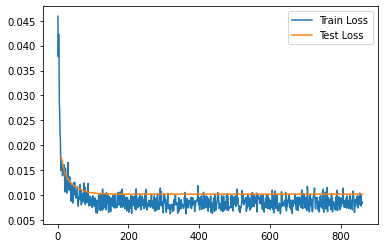

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 861 	Loss: 0.007961
Train Epoch: 861 	Loss: 0.008763
Train Epoch: 861 	Loss: 0.009376


Train Epoch: 862 	Loss: 0.008616
Train Epoch: 862 	Loss: 0.010601
Train Epoch: 862 	Loss: 0.007885


Train Epoch: 863 	Loss: 0.007124
Train Epoch: 863 	Loss: 0.007538
Train Epoch: 863 	Loss: 0.009513


Train Epoch: 864 	Loss: 0.007205
Train Epoch: 864 	Loss: 0.011936
Train Epoch: 864 	Loss: 0.008035


Train Epoch: 865 	Loss: 0.010528
Train Epoch: 865 	Loss: 0.007747
Train Epoch: 865 	Loss: 0.008222


Train Epoch: 866 	Loss: 0.009685
Train Epoch: 866 	Loss: 0.007643
Train Epoch: 866 	Loss: 0.008352


Train Epoch: 867 	Loss: 0.010334
Train Epoch: 867 	Loss: 0.006599
Train Epoch: 867 	Loss: 0.008562


Train Epoch: 868 	Loss: 0.007612
Train Epoch: 868 	Loss: 0.007487
Train Epoch: 868 	Loss: 0.007428


Train Epoch: 869 	Loss: 0.009268
Train Epoch: 869 	Loss: 0.008192
Train Epoch: 869 	Loss: 0.006839


Train Epoch: 870 	Loss: 0.007681
Train Epoch: 870 	Loss: 0.008429
Train Epoch: 870 	Loss: 0

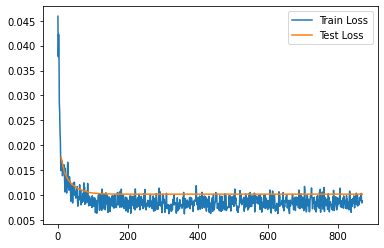

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 871 	Loss: 0.010047
Train Epoch: 871 	Loss: 0.008466
Train Epoch: 871 	Loss: 0.008400


Train Epoch: 872 	Loss: 0.006691
Train Epoch: 872 	Loss: 0.008384
Train Epoch: 872 	Loss: 0.010478


Train Epoch: 873 	Loss: 0.009762
Train Epoch: 873 	Loss: 0.009994
Train Epoch: 873 	Loss: 0.008592


Train Epoch: 874 	Loss: 0.006496
Train Epoch: 874 	Loss: 0.008373
Train Epoch: 874 	Loss: 0.008242


Train Epoch: 875 	Loss: 0.009027
Train Epoch: 875 	Loss: 0.009655
Train Epoch: 875 	Loss: 0.009310


Train Epoch: 876 	Loss: 0.007039
Train Epoch: 876 	Loss: 0.008235
Train Epoch: 876 	Loss: 0.009514


Train Epoch: 877 	Loss: 0.009796
Train Epoch: 877 	Loss: 0.007896
Train Epoch: 877 	Loss: 0.009382


Train Epoch: 878 	Loss: 0.007450
Train Epoch: 878 	Loss: 0.009034
Train Epoch: 878 	Loss: 0.007951


Train Epoch: 879 	Loss: 0.008421
Train Epoch: 879 	Loss: 0.007631
Train Epoch: 879 	Loss: 0.008129


Train Epoch: 880 	Loss: 0.008239
Train Epoch: 880 	Loss: 0.008583
Train Epoch: 880 	Loss: 0

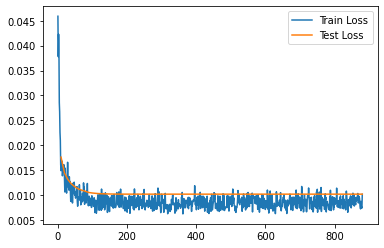

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 881 	Loss: 0.009569
Train Epoch: 881 	Loss: 0.008346
Train Epoch: 881 	Loss: 0.009428


Train Epoch: 882 	Loss: 0.009274
Train Epoch: 882 	Loss: 0.007396
Train Epoch: 882 	Loss: 0.009804


Train Epoch: 883 	Loss: 0.007705
Train Epoch: 883 	Loss: 0.009494
Train Epoch: 883 	Loss: 0.007947


Train Epoch: 884 	Loss: 0.010446
Train Epoch: 884 	Loss: 0.009390
Train Epoch: 884 	Loss: 0.008032


Train Epoch: 885 	Loss: 0.008134
Train Epoch: 885 	Loss: 0.008235
Train Epoch: 885 	Loss: 0.009241


Train Epoch: 886 	Loss: 0.007797
Train Epoch: 886 	Loss: 0.008273
Train Epoch: 886 	Loss: 0.008545


Train Epoch: 887 	Loss: 0.011952
Train Epoch: 887 	Loss: 0.008349
Train Epoch: 887 	Loss: 0.008008


Train Epoch: 888 	Loss: 0.008343
Train Epoch: 888 	Loss: 0.007558
Train Epoch: 888 	Loss: 0.009249


Train Epoch: 889 	Loss: 0.007403
Train Epoch: 889 	Loss: 0.007888
Train Epoch: 889 	Loss: 0.008638


Train Epoch: 890 	Loss: 0.007632
Train Epoch: 890 	Loss: 0.007911
Train Epoch: 890 	Loss: 0

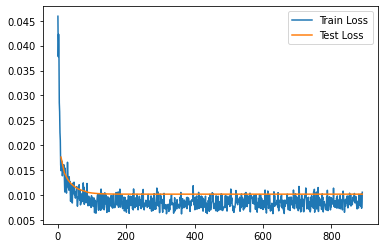

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 891 	Loss: 0.007262
Train Epoch: 891 	Loss: 0.008971
Train Epoch: 891 	Loss: 0.008194


Train Epoch: 892 	Loss: 0.006869
Train Epoch: 892 	Loss: 0.007657
Train Epoch: 892 	Loss: 0.009135


Train Epoch: 893 	Loss: 0.010318
Train Epoch: 893 	Loss: 0.010320
Train Epoch: 893 	Loss: 0.007635


Train Epoch: 894 	Loss: 0.008732
Train Epoch: 894 	Loss: 0.011139
Train Epoch: 894 	Loss: 0.007444


Train Epoch: 895 	Loss: 0.007851
Train Epoch: 895 	Loss: 0.009390
Train Epoch: 895 	Loss: 0.007310


Train Epoch: 896 	Loss: 0.008022
Train Epoch: 896 	Loss: 0.007563
Train Epoch: 896 	Loss: 0.007128


Train Epoch: 897 	Loss: 0.007308
Train Epoch: 897 	Loss: 0.007743
Train Epoch: 897 	Loss: 0.007904


Train Epoch: 898 	Loss: 0.007286
Train Epoch: 898 	Loss: 0.009814
Train Epoch: 898 	Loss: 0.009220


Train Epoch: 899 	Loss: 0.009199
Train Epoch: 899 	Loss: 0.009387
Train Epoch: 899 	Loss: 0.007801


Train Epoch: 900 	Loss: 0.009527
Train Epoch: 900 	Loss: 0.007651
Train Epoch: 900 	Loss: 0

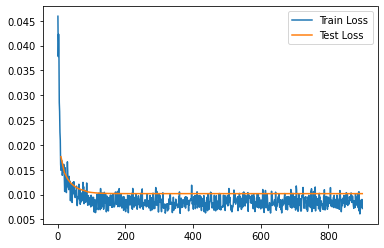

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 901 	Loss: 0.009093
Train Epoch: 901 	Loss: 0.007908
Train Epoch: 901 	Loss: 0.008202


Train Epoch: 902 	Loss: 0.010766
Train Epoch: 902 	Loss: 0.007858
Train Epoch: 902 	Loss: 0.009776


Train Epoch: 903 	Loss: 0.009790
Train Epoch: 903 	Loss: 0.008091
Train Epoch: 903 	Loss: 0.007505


Train Epoch: 904 	Loss: 0.009820
Train Epoch: 904 	Loss: 0.007762
Train Epoch: 904 	Loss: 0.007346


Train Epoch: 905 	Loss: 0.006561
Train Epoch: 905 	Loss: 0.007169
Train Epoch: 905 	Loss: 0.008492


Train Epoch: 906 	Loss: 0.007806
Train Epoch: 906 	Loss: 0.007671
Train Epoch: 906 	Loss: 0.008753


Train Epoch: 907 	Loss: 0.007898
Train Epoch: 907 	Loss: 0.008589
Train Epoch: 907 	Loss: 0.006834


Train Epoch: 908 	Loss: 0.008524
Train Epoch: 908 	Loss: 0.008028
Train Epoch: 908 	Loss: 0.006896


Train Epoch: 909 	Loss: 0.007990
Train Epoch: 909 	Loss: 0.008579
Train Epoch: 909 	Loss: 0.007035


Train Epoch: 910 	Loss: 0.008462
Train Epoch: 910 	Loss: 0.007110
Train Epoch: 910 	Loss: 0

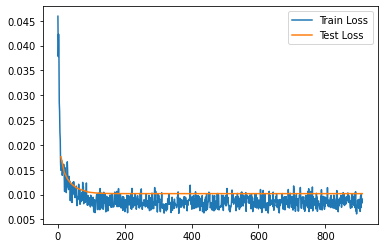

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 911 	Loss: 0.007982
Train Epoch: 911 	Loss: 0.009283
Train Epoch: 911 	Loss: 0.010474


Train Epoch: 912 	Loss: 0.009141
Train Epoch: 912 	Loss: 0.007914
Train Epoch: 912 	Loss: 0.010573


Train Epoch: 913 	Loss: 0.009071
Train Epoch: 913 	Loss: 0.007628
Train Epoch: 913 	Loss: 0.009011


Train Epoch: 914 	Loss: 0.008216
Train Epoch: 914 	Loss: 0.006585
Train Epoch: 914 	Loss: 0.008493


Train Epoch: 915 	Loss: 0.009984
Train Epoch: 915 	Loss: 0.008427
Train Epoch: 915 	Loss: 0.007953


Train Epoch: 916 	Loss: 0.009273
Train Epoch: 916 	Loss: 0.006492
Train Epoch: 916 	Loss: 0.008284


Train Epoch: 917 	Loss: 0.009626
Train Epoch: 917 	Loss: 0.005730
Train Epoch: 917 	Loss: 0.008303


Train Epoch: 918 	Loss: 0.007518
Train Epoch: 918 	Loss: 0.007990
Train Epoch: 918 	Loss: 0.009038


Train Epoch: 919 	Loss: 0.009016
Train Epoch: 919 	Loss: 0.007621
Train Epoch: 919 	Loss: 0.007451


Train Epoch: 920 	Loss: 0.007011
Train Epoch: 920 	Loss: 0.007869
Train Epoch: 920 	Loss: 0

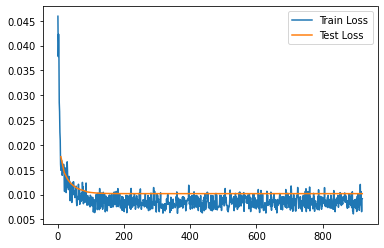

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 921 	Loss: 0.009228
Train Epoch: 921 	Loss: 0.007482
Train Epoch: 921 	Loss: 0.007157


Train Epoch: 922 	Loss: 0.008183
Train Epoch: 922 	Loss: 0.009983
Train Epoch: 922 	Loss: 0.010204


Train Epoch: 923 	Loss: 0.008606
Train Epoch: 923 	Loss: 0.009554
Train Epoch: 923 	Loss: 0.008343


Train Epoch: 924 	Loss: 0.007208
Train Epoch: 924 	Loss: 0.010082
Train Epoch: 924 	Loss: 0.010103


Train Epoch: 925 	Loss: 0.009020
Train Epoch: 925 	Loss: 0.008044
Train Epoch: 925 	Loss: 0.007806


Train Epoch: 926 	Loss: 0.008974
Train Epoch: 926 	Loss: 0.008146
Train Epoch: 926 	Loss: 0.008400


Train Epoch: 927 	Loss: 0.008638
Train Epoch: 927 	Loss: 0.009157
Train Epoch: 927 	Loss: 0.006887


Train Epoch: 928 	Loss: 0.008558
Train Epoch: 928 	Loss: 0.006990
Train Epoch: 928 	Loss: 0.007097


Train Epoch: 929 	Loss: 0.009008
Train Epoch: 929 	Loss: 0.007938
Train Epoch: 929 	Loss: 0.007644


Train Epoch: 930 	Loss: 0.007891
Train Epoch: 930 	Loss: 0.011954
Train Epoch: 930 	Loss: 0

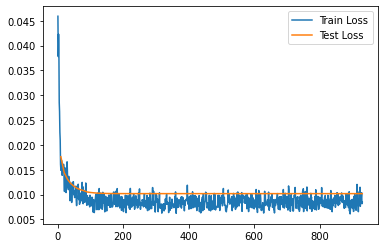

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 931 	Loss: 0.009939
Train Epoch: 931 	Loss: 0.009401
Train Epoch: 931 	Loss: 0.007743


Train Epoch: 932 	Loss: 0.008322
Train Epoch: 932 	Loss: 0.008942
Train Epoch: 932 	Loss: 0.009040


Train Epoch: 933 	Loss: 0.007537
Train Epoch: 933 	Loss: 0.008275
Train Epoch: 933 	Loss: 0.007319


Train Epoch: 934 	Loss: 0.009804
Train Epoch: 934 	Loss: 0.008031
Train Epoch: 934 	Loss: 0.007436


Train Epoch: 935 	Loss: 0.008389
Train Epoch: 935 	Loss: 0.007825
Train Epoch: 935 	Loss: 0.007657


Train Epoch: 936 	Loss: 0.009708
Train Epoch: 936 	Loss: 0.010692
Train Epoch: 936 	Loss: 0.006281


Train Epoch: 937 	Loss: 0.008825
Train Epoch: 937 	Loss: 0.008912
Train Epoch: 937 	Loss: 0.008644


Train Epoch: 938 	Loss: 0.008388
Train Epoch: 938 	Loss: 0.010053
Train Epoch: 938 	Loss: 0.007306


Train Epoch: 939 	Loss: 0.011020
Train Epoch: 939 	Loss: 0.009159
Train Epoch: 939 	Loss: 0.008917


Train Epoch: 940 	Loss: 0.006680
Train Epoch: 940 	Loss: 0.009776
Train Epoch: 940 	Loss: 0

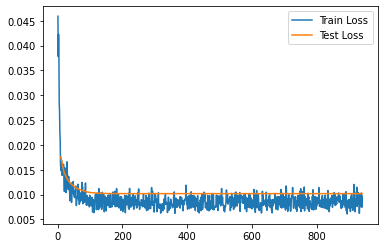

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 941 	Loss: 0.010723
Train Epoch: 941 	Loss: 0.007332
Train Epoch: 941 	Loss: 0.009362


Train Epoch: 942 	Loss: 0.009293
Train Epoch: 942 	Loss: 0.009267
Train Epoch: 942 	Loss: 0.009652


Train Epoch: 943 	Loss: 0.007462
Train Epoch: 943 	Loss: 0.006991
Train Epoch: 943 	Loss: 0.009227


Train Epoch: 944 	Loss: 0.010505
Train Epoch: 944 	Loss: 0.008426
Train Epoch: 944 	Loss: 0.008789


Train Epoch: 945 	Loss: 0.010048
Train Epoch: 945 	Loss: 0.009153
Train Epoch: 945 	Loss: 0.008299


Train Epoch: 946 	Loss: 0.008827
Train Epoch: 946 	Loss: 0.008016
Train Epoch: 946 	Loss: 0.008742


Train Epoch: 947 	Loss: 0.007884
Train Epoch: 947 	Loss: 0.008360
Train Epoch: 947 	Loss: 0.006974


Train Epoch: 948 	Loss: 0.009328
Train Epoch: 948 	Loss: 0.010597
Train Epoch: 948 	Loss: 0.008601


Train Epoch: 949 	Loss: 0.008156
Train Epoch: 949 	Loss: 0.009383
Train Epoch: 949 	Loss: 0.006523


Train Epoch: 950 	Loss: 0.009569
Train Epoch: 950 	Loss: 0.007343
Train Epoch: 950 	Loss: 0

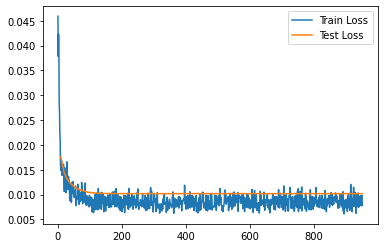

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 951 	Loss: 0.009152
Train Epoch: 951 	Loss: 0.008625
Train Epoch: 951 	Loss: 0.007403


Train Epoch: 952 	Loss: 0.009207
Train Epoch: 952 	Loss: 0.008287
Train Epoch: 952 	Loss: 0.008284


Train Epoch: 953 	Loss: 0.007344
Train Epoch: 953 	Loss: 0.007557
Train Epoch: 953 	Loss: 0.008917


Train Epoch: 954 	Loss: 0.008564
Train Epoch: 954 	Loss: 0.010615
Train Epoch: 954 	Loss: 0.009299


Train Epoch: 955 	Loss: 0.009059
Train Epoch: 955 	Loss: 0.009377
Train Epoch: 955 	Loss: 0.009233


Train Epoch: 956 	Loss: 0.009523
Train Epoch: 956 	Loss: 0.009676
Train Epoch: 956 	Loss: 0.009224


Train Epoch: 957 	Loss: 0.009094
Train Epoch: 957 	Loss: 0.008345
Train Epoch: 957 	Loss: 0.008204


Train Epoch: 958 	Loss: 0.008425
Train Epoch: 958 	Loss: 0.006767
Train Epoch: 958 	Loss: 0.009413


Train Epoch: 959 	Loss: 0.008668
Train Epoch: 959 	Loss: 0.010125
Train Epoch: 959 	Loss: 0.007300


Train Epoch: 960 	Loss: 0.008028
Train Epoch: 960 	Loss: 0.008683
Train Epoch: 960 	Loss: 0

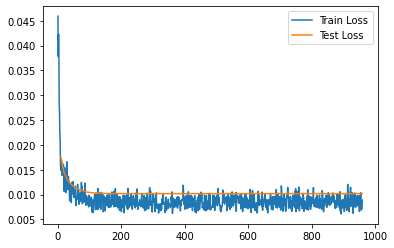

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 961 	Loss: 0.007366
Train Epoch: 961 	Loss: 0.006539
Train Epoch: 961 	Loss: 0.008491


Train Epoch: 962 	Loss: 0.008618
Train Epoch: 962 	Loss: 0.008625
Train Epoch: 962 	Loss: 0.008393


Train Epoch: 963 	Loss: 0.008997
Train Epoch: 963 	Loss: 0.009787
Train Epoch: 963 	Loss: 0.009445


Train Epoch: 964 	Loss: 0.009902
Train Epoch: 964 	Loss: 0.009844
Train Epoch: 964 	Loss: 0.008704


Train Epoch: 965 	Loss: 0.007752
Train Epoch: 965 	Loss: 0.008941
Train Epoch: 965 	Loss: 0.009383


Train Epoch: 966 	Loss: 0.009687
Train Epoch: 966 	Loss: 0.009061
Train Epoch: 966 	Loss: 0.008154


Train Epoch: 967 	Loss: 0.008757
Train Epoch: 967 	Loss: 0.010298
Train Epoch: 967 	Loss: 0.009953


Train Epoch: 968 	Loss: 0.009048
Train Epoch: 968 	Loss: 0.008971
Train Epoch: 968 	Loss: 0.009336


Train Epoch: 969 	Loss: 0.007575
Train Epoch: 969 	Loss: 0.008778
Train Epoch: 969 	Loss: 0.007468


Train Epoch: 970 	Loss: 0.009864
Train Epoch: 970 	Loss: 0.006073
Train Epoch: 970 	Loss: 0

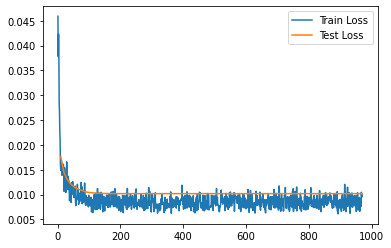

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 971 	Loss: 0.008942
Train Epoch: 971 	Loss: 0.009633
Train Epoch: 971 	Loss: 0.008705


Train Epoch: 972 	Loss: 0.009206
Train Epoch: 972 	Loss: 0.008148
Train Epoch: 972 	Loss: 0.008526


Train Epoch: 973 	Loss: 0.009667
Train Epoch: 973 	Loss: 0.007544
Train Epoch: 973 	Loss: 0.008740


Train Epoch: 974 	Loss: 0.008370
Train Epoch: 974 	Loss: 0.008252
Train Epoch: 974 	Loss: 0.009382


Train Epoch: 975 	Loss: 0.009513
Train Epoch: 975 	Loss: 0.008615
Train Epoch: 975 	Loss: 0.011228


Train Epoch: 976 	Loss: 0.008826
Train Epoch: 976 	Loss: 0.008497
Train Epoch: 976 	Loss: 0.008224


Train Epoch: 977 	Loss: 0.009153
Train Epoch: 977 	Loss: 0.010800
Train Epoch: 977 	Loss: 0.008015


Train Epoch: 978 	Loss: 0.007925
Train Epoch: 978 	Loss: 0.007920
Train Epoch: 978 	Loss: 0.008816


Train Epoch: 979 	Loss: 0.009167
Train Epoch: 979 	Loss: 0.007596
Train Epoch: 979 	Loss: 0.007413


Train Epoch: 980 	Loss: 0.006557
Train Epoch: 980 	Loss: 0.008858
Train Epoch: 980 	Loss: 0

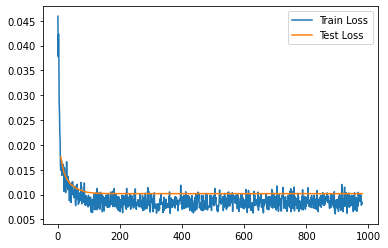

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 981 	Loss: 0.009204
Train Epoch: 981 	Loss: 0.009338
Train Epoch: 981 	Loss: 0.009463


Train Epoch: 982 	Loss: 0.007527
Train Epoch: 982 	Loss: 0.009671
Train Epoch: 982 	Loss: 0.008476


Train Epoch: 983 	Loss: 0.008118
Train Epoch: 983 	Loss: 0.007168
Train Epoch: 983 	Loss: 0.007357


Train Epoch: 984 	Loss: 0.009460
Train Epoch: 984 	Loss: 0.008978
Train Epoch: 984 	Loss: 0.008955


Train Epoch: 985 	Loss: 0.008830
Train Epoch: 985 	Loss: 0.007845
Train Epoch: 985 	Loss: 0.008814


Train Epoch: 986 	Loss: 0.009116
Train Epoch: 986 	Loss: 0.008640
Train Epoch: 986 	Loss: 0.007807


Train Epoch: 987 	Loss: 0.010162
Train Epoch: 987 	Loss: 0.007630
Train Epoch: 987 	Loss: 0.008594


Train Epoch: 988 	Loss: 0.008811
Train Epoch: 988 	Loss: 0.009431
Train Epoch: 988 	Loss: 0.009642


Train Epoch: 989 	Loss: 0.008719
Train Epoch: 989 	Loss: 0.009257
Train Epoch: 989 	Loss: 0.010462


Train Epoch: 990 	Loss: 0.008544
Train Epoch: 990 	Loss: 0.009166
Train Epoch: 990 	Loss: 0

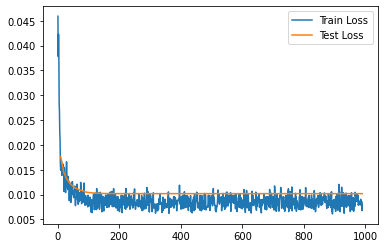

Model and Loss Saved!




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 991 	Loss: 0.009316
Train Epoch: 991 	Loss: 0.009475
Train Epoch: 991 	Loss: 0.007941


Train Epoch: 992 	Loss: 0.008402
Train Epoch: 992 	Loss: 0.009857
Train Epoch: 992 	Loss: 0.008276


Train Epoch: 993 	Loss: 0.006726
Train Epoch: 993 	Loss: 0.009961
Train Epoch: 993 	Loss: 0.008253


Train Epoch: 994 	Loss: 0.008308
Train Epoch: 994 	Loss: 0.009866
Train Epoch: 994 	Loss: 0.009495


Train Epoch: 995 	Loss: 0.009425
Train Epoch: 995 	Loss: 0.006824
Train Epoch: 995 	Loss: 0.008721


Train Epoch: 996 	Loss: 0.007544
Train Epoch: 996 	Loss: 0.008367
Train Epoch: 996 	Loss: 0.008647


Train Epoch: 997 	Loss: 0.007950
Train Epoch: 997 	Loss: 0.009300
Train Epoch: 997 	Loss: 0.008470


Train Epoch: 998 	Loss: 0.009203
Train Epoch: 998 	Loss: 0.009670
Train Epoch: 998 	Loss: 0.008744


Train Epoch: 999 	Loss: 0.008068
Train Epoch: 999 	Loss: 0.008360
Train Epoch: 999 	Loss: 0.010062


Train Epoch: 1000 	Loss: 0.009398
Train Epoch: 1000 	Loss: 0.007700
Train Epoch: 1000 	Loss

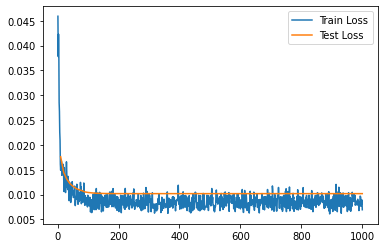

Model and Loss Saved!





In [13]:
epochs = 1000
save_model_and_losses = True
load_saved_model = False
save_after = 50 #epocs (saves model and graphs)

root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab'
save_model_name = "fold_5.pt"

### Create folders if not exists
saved_model_pth = os.path.join(os.path.join(root,save_model_name))
if not os.path.exists(root):
    os.mkdir(root)

if os.path.exists(saved_model_pth) and load_saved_model:
    
    model.load_state_dict(torch.load(saved_model_pth))

if not os.path.exists(os.path.join(root,'plots')):
    os.mkdir(os.path.join(root,'plots'))


model = AugmentedAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
store_train_loss = []
store_test_loss = []

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)

    if epoch % save_after ==0:
        test(model, device, test_loader,save_img=True, ep = epoch, save_folder=root)
        
        if save_model_and_losses:
            torch.save(model.state_dict(), saved_model_pth)

            np.save(os.path.join(root,'plots','train_losss.npy')
                        , store_train_loss)
            
            np.save(os.path.join(root,'plots','test_losss.npy')
                        , store_test_loss)
            
            loss_plotter(store_train_loss, store_test_loss,epoch,root)
            print('Model and Loss Saved!')
    print('\n')

# Validate with your own Image

In [9]:
def cross_validation(model, device, test_loader,ep = None, viewer=True, save_folder =None):
    model.eval()
    test_loss = 0
    correct = 0
    images_show = 8
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        sample = sample.to(device).float()
        
        output = model(sample)
        encodings = model.encoder_op(sample)
        op = output[:images_show,:].cpu()
        tar = sample[:images_show,:].cpu()

    if viewer:
        print('Reconstructed')
        imshow(torchvision.utils.make_grid(op,**kwargs))
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save_folder is not None:
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder,'validate_res.jpg'),**kwargs)
        
    return sample, output, encodings

def imshow(img, images_show = 8,ret_grid = False):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    if ret_grid:
        return npimg
    plt.imshow(npimg)
    plt.show()

def generate_encoding_table(model, device, train_loader):
    model.eval()
    table = {}
    with torch.no_grad():
        for batch_idx, sample in enumerate(train_loader):
            # print(f"Processing batch: {batch_idx}/{len(train_loader)}")
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            # output = model(data)
            encodings = model.encoder_op(target)
            for i in range(len(encodings)):
                table[target[i,:,:,:].cpu()] = encodings[i,:].cpu()          
            # kwargs =  {'nrow':4, "padding":2, "pad_value":1}
            # for img, encoding in table.items():
            #     imshow(torchvision.utils.make_grid(img, **kwargs))   
    print("Table Generated!")
    return table


def top_n_similar_result(table, real_img_enc,real_img,reconstructed_real_img, n = 5, viewer=False):
    kwargs = {'nrow':4, "padding":2, "pad_value":1}
    loss = nn.MSELoss()
    real_img_enc = real_img_enc.cpu()
    max_similarity = -2.0
    enc_to_img = {}
    
    for table_img, table_encoding in table.items():
        similarity = F.conv2d(reconstructed_real_img.unsqueeze(0),
                              table_img.unsqueeze(0)).squeeze()
        enc_to_img[(similarity)] = table_img.unsqueeze(0)
        # print(similarity)

    sorted_encodings = sorted(enc_to_img.keys())
    most_similar_img = real_img.unsqueeze(0)
    most_similar_img = torch.cat((most_similar_img, 
                                  reconstructed_real_img.unsqueeze(0)),dim=0)
    for i in range(1,n+1):  
        most_similar_img = torch.cat((most_similar_img, enc_to_img[sorted_encodings[-i]]),dim=0)
    most_similar_img = imshow(torchvision.utils.make_grid(most_similar_img, **kwargs), ret_grid = True) 
    return  torch.tensor(most_similar_img), sorted_encodings[-1]

## Load validation Images

- Load dataset which only consists of real images and just change the folder in variable `origami_test_dir`
- change `root` path to save your validation results or to load previously trained model

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Reconstructed


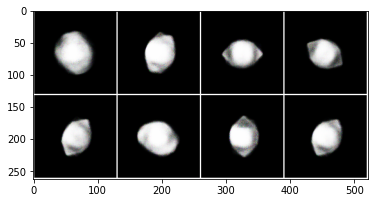

Input to Netowrk


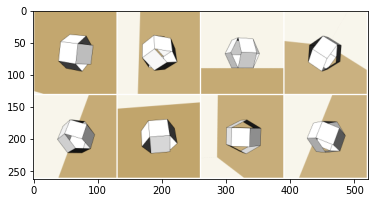

Table Generated!
Table has:  480 entries


In [14]:
origami_validate_dir = "/content/Origami-Dataset/HapticOrigami/Fold_0.7/Input"

## Loading and inferening model
root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab/haptic_5'
save_model_name = "fold_5.pt"

val_batch_size = 10
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(),ToTensorValidate() ])
validator = ValidationGenerate(root_dir=origami_validate_dir, transform=trns)
val_loader = DataLoader(validator, batch_size=val_batch_size,
                            shuffle=True,**kwargs)


saved_model_pth = os.path.join(root,save_model_name)
if not os.path.exists(saved_model_pth):
    print('saved file not found!')

val_img_save_folder = os.path.join(os.path.join(root,'validation_results'))
if not os.path.exists(val_img_save_folder):
    os.mkdir(val_img_save_folder)

model = AugmentedAutoencoder().to(device)
# summary(model,(3,128,128))
model.load_state_dict(torch.load(saved_model_pth))
sample, output, encodings = cross_validation(model, device, val_loader,
                                             save_folder = val_img_save_folder)
table = generate_encoding_table(model, device, train_loader)

print('Table has: ', len(table.keys()), 'entries')

Top 4 most similar images 

Display Order: Input Image -> Recontructed Image -> Top n image
Maximum similarity: 6103.90087890625


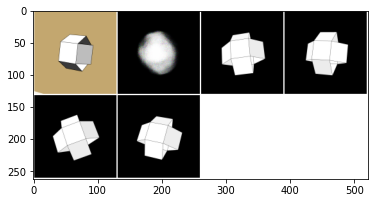

Maximum similarity: 5541.357421875


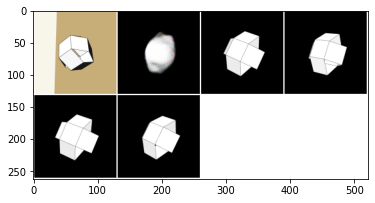

Maximum similarity: 4261.28076171875


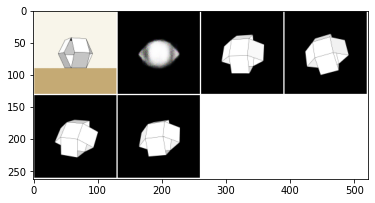

Maximum similarity: 3942.634765625


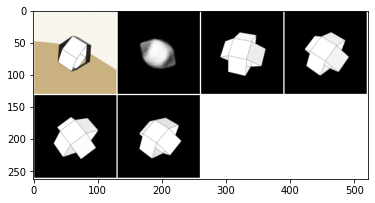

Maximum similarity: 4495.1650390625


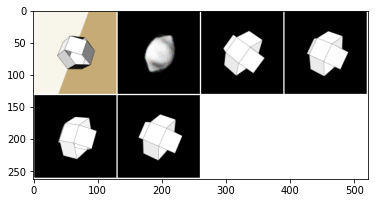

Maximum similarity: 5991.0478515625


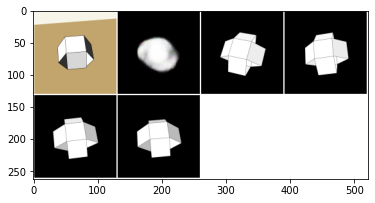

Maximum similarity: 4359.748046875


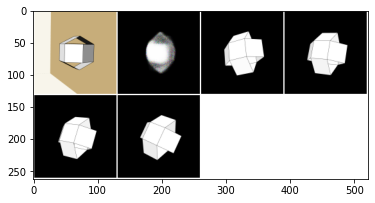

In [15]:
top_n = 4
print(f'Top {top_n} most similar images \n')
print(f'Display Order: Input Image -> Recontructed Image -> Top n image')
for i in range(7):
    real_img = sample[i,:].cpu()
    reconstructed_real_img = output[i,:].cpu()
    real_img_enc = encodings[i,:]
    most_similar_img, max_similarity = top_n_similar_result(table, real_img_enc,real_img,
                                                            reconstructed_real_img, n = top_n)
    print(f'Maximum similarity: {max_similarity}')

    plt.imshow(most_similar_img)
    plt.show()